# Compilado de notas y código automatizado

Este cuaderno reúne los procesos de cada actividad en orden y, posteriormente, **todo el código** consolidado para su ejecución automática. 

---
Paso 1: Selección de variables
---

En este paso se carga la base de datos original y se seleccionan únicamente 
las columnas relevantes para el análisis. Esto permite reducir el DataFrame 
a la información necesaria desde el inicio, evitando ruido y optimizando 
el rendimiento en los pasos posteriores.

---
Paso 2: Traducción de variables
---

Se renombran las columnas seleccionadas al español, utilizando un diccionario 
de traducción. Esto facilita la interpretación, uniformiza los nombres y asegura 
coherencia en toda la documentación y análisis.

---
Paso 3: Imputación de 'banos', 'recamaras', 'camas' y 'texto_banos'
---

Se rellenan valores faltantes en las variables relacionadas con baños, recámaras 
y camas. 

- `texto_banos` se completa con la moda y se convierte a un valor numérico (`banos`).  
- Los casos con "half-bath" se convierten en 0.5.  
- `banos`, `recamaras` y `camas` se imputan con moda o mediana según corresponda.  

De esta forma se homogenizan variables clave para el análisis de capacidad de alojamiento.

---
Paso 4: Conversión y tratamiento de 'precio'
---

Se eliminan los símbolos de moneda y separadores de miles de la columna `precio`, 
convirtiéndola a valores numéricos.  
Los valores faltantes se imputan con la media, lo que permite mantener todas las observaciones 
y tener un proxy central para los casos sin datos.

---
Paso 5: Imputación de valores nulos en variables de reseñas
---

- Las fechas de reseñas (`primera_resena`, `ultima_resena`) se imputan con un valor 
  **centinela futuro (2222-01-01)**, de modo que se distingan de valores válidos.  
- Los indicadores numéricos de reseñas y calificaciones se imputan con un centinela **-222**, 
  indicando explícitamente que no hay datos.  

Esto permite mantener consistencia y diferenciar datos ausentes de valores reales.

---
Paso 6: Imputación de valores nulos en variables categóricas
---

Se rellenan las variables categóricas con valores específicos:  

- `es_superhost` y `tiempo_respuesta_host` → `"SIN_INFO"`.  
- `licencia` → código ficticio `"SL222222X2XX2XXXX2"`.  

Así se conserva cada registro y se distinguen los datos faltantes de los originales.

---
Paso 7: Imputación con la moda para columnas con pocos nulos
---

Para columnas con pocos faltantes (`host_tiene_foto`, `host_verificado`, 
`listados_host`, `total_listados_host`, `antiguedad_host`), se imputa con la moda.  

Esto asegura que el impacto en la distribución sea mínimo y mantiene homogeneidad.

---
Paso 8: Conversión y tratamiento de porcentajes
---

Las columnas `tasa_respuesta_host` y `tasa_aceptacion_host` se convierten de porcentaje 
a proporción decimal.  
Los valores faltantes se imputan con el centinela **222**, evitando perder registros 
y diferenciando los casos sin información.

---
Paso 9: Tratamiento de valores atípicos
---

Se define una lista de anfitriones a excluir (IDs atípicos).  
En este caso, se utilizó un **ID ficticio** para no excluir ninguno realmente.  

Esto se hizo porque:  
**Para un análisis general más homogéneo se decidió mantener estos anfitriones en todas las bases 
y luego imputarlos por otro medio.**  

Los registros de anfitriones definidos como outliers se exportan a un archivo aparte 
para referencia.

---
Paso 10: Exclusión de registros atípicos
---

Se eliminan los registros de anfitriones listados como outliers, generando 
una base de datos limpia sin estos casos.  
El resultado se exporta en un CSV para su uso posterior.

---
Paso 11: Generación de boxplots para detección de atípicos
---

Los centinelas se reemplazan por `NaN` temporalmente y se generan diagramas 
de caja (boxplots) para todas las variables numéricas.  

Esto permite detectar gráficamente valores extremos y comprender la dispersión 
de los datos.

---
Paso 12: Verificación de rangos de calificación
---

Se verifica que todas las calificaciones estén en el rango **0–5**.  
Si se encuentran valores fuera de rango, se reportan y se ajustan.  

Esto asegura consistencia y mantiene la escala estandarizada de calificaciones.

---
Paso 13: Comparación de estadísticas antes y después
---

Se comparan estadísticas descriptivas (mínimo, media, máximo) antes y después 
de excluir outliers.  
Los resultados se exportan en un archivo Excel con dos pestañas para contrastar.  

Esto permite validar el impacto de la exclusión de valores atípicos.

---
Paso 13.5: Limpieza de outliers respetando centinelas
---

Se aplica una limpieza más detallada:  

1. Los centinelas se reemplazan por `NaN` temporalmente para el análisis.  
2. Se corrigen calificaciones al rango [0, 5].  
3. Se seleccionan columnas numéricas y se aplica el método IQR, 
   excluyendo `banos` y `tasa_respuesta_host`.  
4. Los outliers se reemplazan con la mediana de cada variable.  

De esta manera se ajustan valores extremos sin eliminar registros y manteniendo 
la coherencia en todos los dataset finales.

---
Paso 14: Análisis univariado de variables categóricas
---

Se exploran las variables categóricas.  
- Se listan las categorías más frecuentes (top 10 o top 9 + `SIN_INFO`).  
- Se generan gráficos de barras y gráficos de pastel, agrupando categorías menores en “Otros”.  

Esto facilita la identificación de patrones en variables no numéricas.

---
Paso 15: Distribución para discretas y categorización para continuas
---

- Las variables discretas (`capacidad`, `banos`, `camas`) se agrupan en **categorías fijas** de 0 a 14.  
- Las variables continuas se dividen en **15 rangos (bins)** para estandarizar la comparación.  
- Los rangos se grafican y se generan frecuencias categóricas.  

Esto uniformiza la distribución de variables numéricas para facilitar análisis posteriores.

---
Paso 16: Exportación del DataFrame final
---

Se exporta la base final ya depurada en un archivo `<BASE_NAME>_FINAL.csv`.  

En esta versión **se mantienen los centinelas**, lo cual asegura coherencia 
y permite aplicar imputaciones adicionales en etapas posteriores del análisis.


## Código consolidado y automatizado

In [99]:
# =========================================================================
# Configuración inicial
# =========================================================================
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import log10

# Nombre de la base de datos (en la misma carpeta que este script)
BASE_DE_DATOS = "Washington.csv"

# =========================================================================
# Rutas de entrada y salida
# =========================================================================
CARPETA_TRABAJO = Path.cwd()
BASE_NAME = Path(BASE_DE_DATOS).stem

INPUT_FILE = CARPETA_TRABAJO / BASE_DE_DATOS

OUTPUT_FILTRADO_ES   = CARPETA_TRABAJO / f"{BASE_NAME}_Filtrado_ES.csv"
OUTPUT_SIN_NAN       = CARPETA_TRABAJO / f"{BASE_NAME}_Sin_NAs.csv"
OUTPUT_OUTLIERS_CSV  = CARPETA_TRABAJO / f"{BASE_NAME}_Anfitriones_Outliers.csv"
OUTPUT_SIN_OUTLIERS  = CARPETA_TRABAJO / f"{BASE_NAME}_Sin_Outliers.csv"
OUTPUT_EXCEL         = CARPETA_TRABAJO / f"{BASE_NAME}_Estadisticas_comparativas_Sin_Outliers.xlsx"

# Carpeta de gráficos (se crea sin checar)
GRAFICOS_FOLDER = CARPETA_TRABAJO / "graficas_outliers"
GRAFICOS_FOLDER.mkdir(parents=True, exist_ok=True)


In [100]:
# =========================================================================
# Paso 1: Selección de variables
# =========================================================================
print("Paso 1: Selección de variables...")

# Leer CSV
df = pd.read_csv(INPUT_FILE, low_memory=False)

# Variables de interés
variables = [
    "id", "host_id",
    "neighbourhood_group_cleansed", "neighbourhood_cleansed", "latitude", "longitude",
    "property_type", "room_type", "accommodates", "bathrooms", "bedrooms", "beds", "bathrooms_text",
    "minimum_nights", "maximum_nights", "minimum_maximum_nights", "maximum_maximum_nights",
    "price", "availability_30", "availability_60", "availability_90", "availability_365",
    "number_of_reviews", "number_of_reviews_ltm", "number_of_reviews_l30d",
    "first_review", "last_review", "reviews_per_month",
    "review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness",
    "review_scores_checkin", "review_scores_communication", "review_scores_location", "review_scores_value",
    "instant_bookable", "host_is_superhost", "host_since",
    "host_response_time", "host_response_rate", "host_acceptance_rate",
    "host_has_profile_pic", "host_identity_verified",
    "host_listings_count", "host_total_listings_count",
    "calculated_host_listings_count_entire_homes",
    "calculated_host_listings_count_private_rooms",
    "calculated_host_listings_count_shared_rooms",
    "license", "amenities"
]

# Subconjunto del DataFrame
df_filtrado = df[variables]

print("Variables seleccionadas ✅")


Paso 1: Selección de variables...
Variables seleccionadas ✅


In [101]:
# =========================================================================
# Paso 2: Traducción de variables
# =========================================================================
print("Paso 2: Traducción de variables...")

translate_dict = {
    "id": "id",
    "host_id": "id_anfitrion",
    "neighbourhood_group_cleansed": "zona_grupo",
    "neighbourhood_cleansed": "vecindario",
    "latitude": "latitud",
    "longitude": "longitud",
    "property_type": "tipo_propiedad",
    "room_type": "tipo_habitacion",
    "accommodates": "capacidad",
    "bathrooms": "banos",
    "bedrooms": "recamaras",
    "beds": "camas",
    "bathrooms_text": "texto_banos",
    "minimum_nights": "noches_minimas",
    "maximum_nights": "noches_maximas",
    "minimum_maximum_nights": "min_noches_maximas",
    "maximum_maximum_nights": "max_noches_maximas",
    "price": "precio",
    "availability_30": "disp_30d",
    "availability_60": "disp_60d",
    "availability_90": "disp_90d",
    "availability_365": "disp_365d",
    "number_of_reviews": "num_resenas",
    "number_of_reviews_ltm": "num_resenas_12m",
    "number_of_reviews_l30d": "num_resenas_30d",
    "first_review": "primera_resena",
    "last_review": "ultima_resena",
    "reviews_per_month": "resenas_por_mes",
    "review_scores_rating": "calif_total",
    "review_scores_accuracy": "calif_exactitud",
    "review_scores_cleanliness": "calif_limpieza",
    "review_scores_checkin": "calif_checkin",
    "review_scores_communication": "calif_comunicacion",
    "review_scores_location": "calif_ubicacion",
    "review_scores_value": "calif_valor",
    "instant_bookable": "reserva_inmediata",
    "host_is_superhost": "es_superhost",
    "host_since": "antiguedad_host",
    "host_response_time": "tiempo_respuesta_host",
    "host_response_rate": "tasa_respuesta_host",
    "host_acceptance_rate": "tasa_aceptacion_host",
    "host_has_profile_pic": "host_tiene_foto",
    "host_identity_verified": "host_verificado",
    "host_listings_count": "listados_host",
    "host_total_listings_count": "total_listados_host",
    "calculated_host_listings_count_entire_homes": "host_total_casas_completas",
    "calculated_host_listings_count_private_rooms": "host_total_habitaciones_privadas",
    "calculated_host_listings_count_shared_rooms": "host_total_habitaciones_compartidas",
    "license": "licencia",
    "amenities": "amenidades"
}

# Renombrar columnas
df_filtrado = df_filtrado.rename(columns=translate_dict)
df_filtrado.to_csv(OUTPUT_FILTRADO_ES, index=False, encoding="utf-8-sig")

print(f"Archivo '{OUTPUT_FILTRADO_ES.name}' guardado ✅")

# Actualizar df principal
df = df_filtrado


Paso 2: Traducción de variables...
Archivo 'Washington_Filtrado_ES.csv' guardado ✅


In [102]:
# =========================================================================
# Paso 3: Imputación de 'banos', 'recamaras', 'camas' y 'texto_banos'
# =========================================================================
print("\nPaso 3: Imputación de valores nulos...")

# texto_banos → moda
df["texto_banos"] = df["texto_banos"].fillna(df["texto_banos"].mode()[0])

# banos → extraído de texto, con ajuste de half-bath
df["banos"] = df["texto_banos"].str.extract(r"(\d+\.?\d*)", expand=False).astype(float)
df.loc[df["texto_banos"].str.lower().str.contains("half-bath", na=False), "banos"] = 0.5
df["banos"] = df["banos"].fillna(df["banos"].mode()[0])

# recamaras → mediana
df["recamaras"] = df["recamaras"].fillna(df["recamaras"].median())

# camas → moda
df["camas"] = df["camas"].fillna(df["camas"].mode()[0])

print("Imputación completada ✅")



Paso 3: Imputación de valores nulos...
Imputación completada ✅


In [103]:
# =========================================================================
# Paso 4: Conversión y tratamiento de 'precio'
# =========================================================================
print("Paso 4: Conversión y tratamiento de 'precio'...")

s_precio = (
    df["precio"]
    .str.replace(r"[\$,]", "", regex=True)
    .astype(float)
)

df["precio"] = s_precio.fillna(s_precio.mean())

print("Tratamiento de 'precio' completado ✅")



Paso 4: Conversión y tratamiento de 'precio'...
Tratamiento de 'precio' completado ✅


In [104]:
# =========================================================================
# Paso 5: Imputación de valores nulos en variables de reseñas
# =========================================================================
print("Paso 5: Imputación de valores nulos en variables de reseñas...")

SENTINELA_FECHA = pd.to_datetime("2222-01-01")
SENTINELA_NUM = -222

for col in ["primera_resena", "ultima_resena"]:
    df[col] = pd.to_datetime(df[col], errors="coerce").fillna(SENTINELA_FECHA)

for col in [
    "resenas_por_mes", "calif_total", "calif_exactitud", "calif_limpieza",
    "calif_checkin", "calif_comunicacion", "calif_ubicacion", "calif_valor"
]:
    df[col] = df[col].fillna(SENTINELA_NUM)

print("Imputación de variables de reseñas completada ✅")


Paso 5: Imputación de valores nulos en variables de reseñas...
Imputación de variables de reseñas completada ✅


In [105]:
# =========================================================================
# Paso 6: Imputación de valores nulos en variables categóricas
# =========================================================================
print("Paso 6: Imputación de valores nulos en variables categóricas...")

df["es_superhost"] = df["es_superhost"].fillna("SIN_INFO")
df["tiempo_respuesta_host"] = df["tiempo_respuesta_host"].fillna("SIN_INFO")
df["licencia"] = df["licencia"].fillna("SL222222X2XX2XXXX2")

print("Imputación de variables categóricas completada ✅")


Paso 6: Imputación de valores nulos en variables categóricas...
Imputación de variables categóricas completada ✅


In [106]:
# =========================================================================
# Paso 7: Imputación con la moda para columnas con pocos nulos
# =========================================================================
print("Paso 7: Imputación con la moda para columnas con pocos nulos...")

for col in ["host_tiene_foto", "host_verificado", "listados_host", "total_listados_host", "antiguedad_host"]:
    df[col] = df[col].fillna(df[col].mode()[0])

print("Imputación por moda completada ✅")


Paso 7: Imputación con la moda para columnas con pocos nulos...
Imputación por moda completada ✅


In [107]:
# =========================================================================
# Paso 8: Conversión y tratamiento de porcentajes
# =========================================================================
print("Paso 8: Conversión y tratamiento de porcentajes...")

for col in ["tasa_respuesta_host", "tasa_aceptacion_host"]:
    df[col] = df[col].astype(str).str.replace("%", "", regex=False).astype(float) / 100
    df[col] = df[col].fillna(222)

df.to_csv(OUTPUT_SIN_NAN, index=False, encoding="utf-8-sig")
print(f"Archivo '{OUTPUT_SIN_NAN.name}' guardado ✅")


Paso 8: Conversión y tratamiento de porcentajes...
Archivo 'Washington_Sin_NAs.csv' guardado ✅


In [108]:
# =========================================================================
# Paso 9: Tratamiento de valores atípicos
# =========================================================================
print("\nPaso 9: Tratamiento de valores atípicos...")

# IDs de los anfitriones a excluir
anfitriones_excluidos = [9999999992222222222] #ID ficticio para no omitir ninguno en cualquier base y realizar 
# un análisis parejo entre las diversas bases de datos.

# Definir los valores sentinela para el análisis
sentinel_dict_num = {
    'resenas_por_mes': -222, 'calif_total': -222, 'calif_exactitud': -222,
    'calif_limpieza': -222, 'calif_checkin': -222, 'calif_comunicacion': -222,
    'calif_ubicacion': -222, 'calif_valor': -222,
    'tasa_respuesta_host': 222, 'tasa_aceptacion_host': 222
}

# Separar y exportar los registros atípicos
df_outliers = df[df['id_anfitrion'].isin(anfitriones_excluidos)]
df_outliers.to_csv(OUTPUT_OUTLIERS_CSV, index=False)
print(f"Registros de anfitriones outliers exportados a '{OUTPUT_OUTLIERS_CSV.name}' ✅")



Paso 9: Tratamiento de valores atípicos...
Registros de anfitriones outliers exportados a 'Washington_Anfitriones_Outliers.csv' ✅


In [109]:
# =========================================================================
# Paso 10: Exclusión de registros atípicos
# =========================================================================
print("Paso 10: Exclusión de registros atípicos...")

df_sin_outliers = df[~df['id_anfitrion'].isin(anfitriones_excluidos)].copy()
df_sin_outliers.to_csv(OUTPUT_SIN_OUTLIERS, index=False)
print(f"Base de datos sin outliers exportada a '{OUTPUT_SIN_OUTLIERS.name}' ✅")

df = df_sin_outliers.copy()

Paso 10: Exclusión de registros atípicos...
Base de datos sin outliers exportada a 'Washington_Sin_Outliers.csv' ✅


In [110]:
# =========================================================================
# Paso 11: Generación de boxplots para detección de atípicos
# =========================================================================
print("Paso 11: Generación de boxplots para detección de atípicos...")

# Reemplazar centinelas con NaN para la visualización
df_temp = df.copy()
for col, sentinel in sentinel_dict_num.items():
    if col in df_temp.columns:
        df_temp[col] = df_temp[col].replace(sentinel, np.nan)

# Generar y guardar boxplots para cada columna numérica
plt.style.use('fivethirtyeight')
numeric_cols = df_temp.select_dtypes(include=np.number).columns
for col in numeric_cols:
    plt.figure(figsize=(10, 2))
    df_temp[col].plot(kind='box', vert=False)
    plt.title(f'Diagrama de caja de {col}', fontsize=12)
    plt.tight_layout()
    plt.savefig(GRAFICOS_FOLDER / f'boxplot_{col}.png')
    plt.close()

print(f"Diagramas de caja individuales guardados en la carpeta '{GRAFICOS_FOLDER.name}' ✅")

Paso 11: Generación de boxplots para detección de atípicos...
Diagramas de caja individuales guardados en la carpeta 'graficas_outliers' ✅


In [111]:
# =========================================================================
# Paso 12: Verificación de rangos de calificación
# =========================================================================
print("Paso 12: Verificación de rangos de calificación...")

# Columnas de calificación a verificar
calif_cols = [
    'calif_total', 'calif_exactitud', 'calif_limpieza', 'calif_checkin',
    'calif_comunicacion', 'calif_ubicacion', 'calif_valor'
]

# Verificar si los valores de calificación están entre 0 y 5
print("\nVerificando que los valores de calificación estén entre 0 y 5:")
for col in calif_cols:
    is_in_range = df_temp[col].between(0, 5, inclusive='both').all()
    
    if is_in_range:
        print(f"  - '{col}': Todos los valores están en el rango de 0 a 5. ✅")
    else:
        print(f"  - '{col}': ¡ATENCIÓN! Se encontraron valores fuera del rango de 0 a 5. ❌")

Paso 12: Verificación de rangos de calificación...

Verificando que los valores de calificación estén entre 0 y 5:
  - 'calif_total': ¡ATENCIÓN! Se encontraron valores fuera del rango de 0 a 5. ❌
  - 'calif_exactitud': ¡ATENCIÓN! Se encontraron valores fuera del rango de 0 a 5. ❌
  - 'calif_limpieza': ¡ATENCIÓN! Se encontraron valores fuera del rango de 0 a 5. ❌
  - 'calif_checkin': ¡ATENCIÓN! Se encontraron valores fuera del rango de 0 a 5. ❌
  - 'calif_comunicacion': ¡ATENCIÓN! Se encontraron valores fuera del rango de 0 a 5. ❌
  - 'calif_ubicacion': ¡ATENCIÓN! Se encontraron valores fuera del rango de 0 a 5. ❌
  - 'calif_valor': ¡ATENCIÓN! Se encontraron valores fuera del rango de 0 a 5. ❌


In [112]:
# =========================================================================
# Paso 13: Comparación de estadísticas antes y después
# =========================================================================
print("Paso 13: Comparación de estadísticas antes y después...")

df_antes = pd.read_csv(OUTPUT_SIN_NAN).replace(sentinel_dict_num, np.nan)

stats_antes = df_antes.select_dtypes(include=np.number).agg(['min', 'mean', 'max'])
stats_despues = df_sin_outliers.select_dtypes(include=np.number).agg(['min', 'mean', 'max'])

with pd.ExcelWriter(OUTPUT_EXCEL) as writer:
    stats_antes.to_excel(writer, sheet_name='Estadisticas Antes de Excluir')
    stats_despues.to_excel(writer, sheet_name='Estadisticas Despues de Excluir')

print(f"Estadísticas comparativas guardadas en '{OUTPUT_EXCEL.name}' ✅")

Paso 13: Comparación de estadísticas antes y después...
Estadísticas comparativas guardadas en 'Washington_Estadisticas_comparativas_Sin_Outliers.xlsx' ✅


In [113]:
# =========================================================================
# Paso 13.5: Limpieza de outliers respetando centinelas
# =========================================================================
print("\nPaso 13.5: Limpieza de outliers respetando centinelas (excluye IQR en 'banos' y 'tasa_respuesta_host')")

# DF de trabajo coherente con pasos previos
df_work = df

# 1) Centinelas → NaN (Usa diccionario del paso 9)
centinela_info = {col: int((df_work[col] == sentinel).sum()) for col, sentinel in sentinel_dict_num.items() if col in df_work.columns}
df_work = df_work.replace(sentinel_dict_num, np.nan)
if any(centinela_info.values()):
    print("Centinelas → NaN:", {k: v for k, v in centinela_info.items() if v})

# 2) Calificaciones: solo confirmar del 0 al 5 (sin IQR)
calif_cols = [
    'calif_total', 'calif_exactitud', 'calif_limpieza', 'calif_checkin',
    'calif_comunicacion', 'calif_ubicacion', 'calif_valor'
]
calif_cols_presentes = [c for c in calif_cols if c in df_work.columns]
rangos_info = {}
for col in calif_cols_presentes:
    s = df_work[col]
    fuera = s.notna() & ((s < 0) | (s > 5))
    if fuera.any():
        df_work[col] = s.clip(lower=0, upper=5)
        rangos_info[col] = int(fuera.sum())

# 3) Numéricas para IQR (excluye IDs, calificaciones)
excluir_iqr_cols = ['tasa_respuesta_host', 'banos']
num_cols = df_work.select_dtypes(include=[np.number]).columns.tolist()
excluir = {"id", "id_anfitrion", *calif_cols_presentes, *excluir_iqr_cols}
num_cols = [c for c in num_cols if c not in excluir]

print("Columnas tratadas con IQR (excluye IDs, calificaciones y pedidas):", num_cols)
print("Columnas excluidas explícitamente del IQR:", excluir_iqr_cols)

# 4) IQR + reemplazo de outliers por mediana (no-outliers)
outliers_info = {}
for col in num_cols:
    s = df_work[col].astype(float)
    s_nonnull = s.dropna()
    if s_nonnull.empty:
        continue
    Q1, Q3 = s_nonnull.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    mask_out = s.notna() & ~s.between(lower, upper)
    if mask_out.any():
        median_no_outliers = s[~mask_out].median()
        if pd.isna(median_no_outliers):
            median_no_outliers = s.median()
        if not pd.isna(median_no_outliers):
            df_work.loc[mask_out, col] = median_no_outliers
            outliers_info[col] = int(mask_out.sum())

print("✔ Limpieza completada.")
print("  Calificaciones recortadas a [0,5]:" if rangos_info else "  Sin recortes en calificaciones.", rangos_info if rangos_info else "")
print("  Outliers reemplazados (IQR→media):" if outliers_info else "  No se detectaron outliers por IQR en las columnas tratadas.", outliers_info if outliers_info else "")



Paso 13.5: Limpieza de outliers respetando centinelas (excluye IQR en 'banos' y 'tasa_respuesta_host')
Centinelas → NaN: {'resenas_por_mes': 1095, 'calif_total': 1095, 'calif_exactitud': 1096, 'calif_limpieza': 1096, 'calif_checkin': 1096, 'calif_comunicacion': 1096, 'calif_ubicacion': 1096, 'calif_valor': 1096, 'tasa_respuesta_host': 466, 'tasa_aceptacion_host': 300}
Columnas tratadas con IQR (excluye IDs, calificaciones y pedidas): ['zona_grupo', 'latitud', 'longitud', 'capacidad', 'recamaras', 'camas', 'noches_minimas', 'noches_maximas', 'min_noches_maximas', 'max_noches_maximas', 'precio', 'disp_30d', 'disp_60d', 'disp_90d', 'disp_365d', 'num_resenas', 'num_resenas_12m', 'num_resenas_30d', 'resenas_por_mes', 'tasa_aceptacion_host', 'listados_host', 'total_listados_host', 'host_total_casas_completas', 'host_total_habitaciones_privadas', 'host_total_habitaciones_compartidas']
Columnas excluidas explícitamente del IQR: ['tasa_respuesta_host', 'banos']
✔ Limpieza completada.
  Sin rec

Paso 14: Análisis univariado de variables categóricas...
--- Análisis de las categorías más relevantes en cada columna categórica ---

Las categorías más relevantes para 'zona_grupo' son:
   zona_grupo  frecuencia
0         NaN        6423
--------------------------------------------------


C:\Users\navae\AppData\Local\Temp\ipykernel_23804\2675582449.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.barplot(


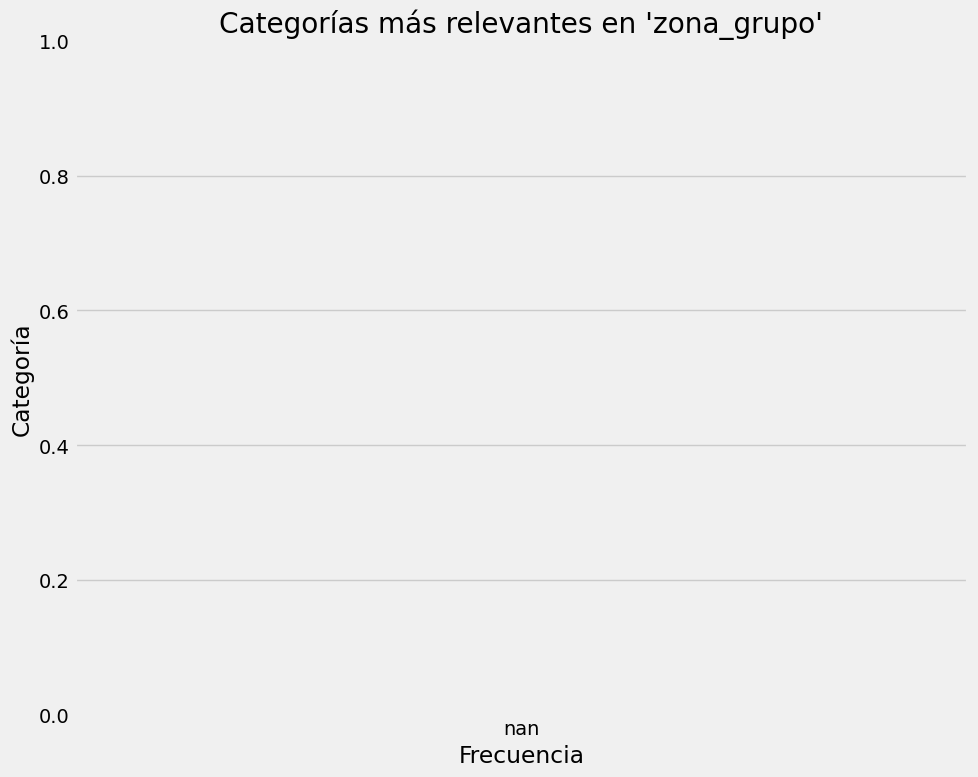

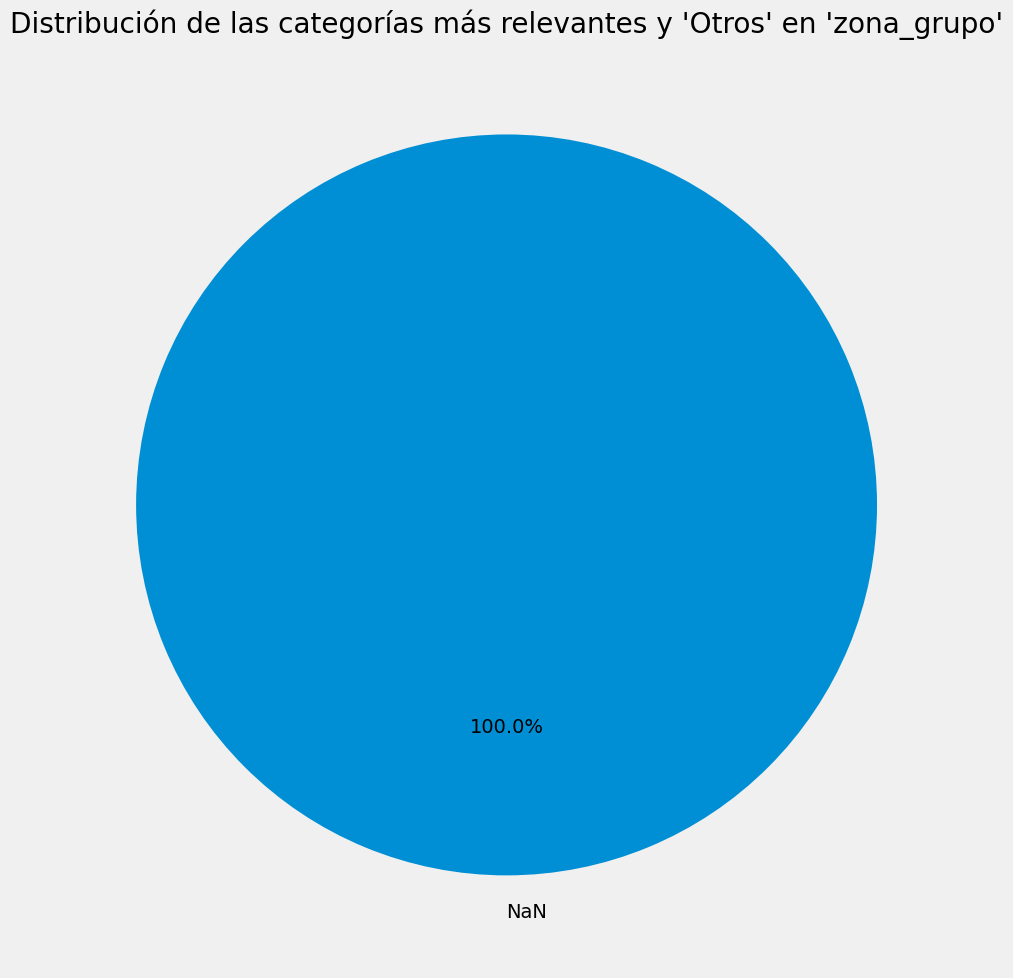


Las categorías más relevantes para 'vecindario' son:
                                           vecindario  frecuencia
0           Union Station, Stanton Park, Kingman Park         704
1                          Capitol Hill, Lincoln Park         602
2          Dupont Circle, Connecticut Avenue/K Street         485
3   Edgewood, Bloomingdale, Truxton Circle, Eckington         467
4   Columbia Heights, Mt. Pleasant, Pleasant Plain...         452
5                Brightwood Park, Crestwood, Petworth         374
6                                  Shaw, Logan Circle         368
7   Downtown, Chinatown, Penn Quarters, Mount Vern...         335
8      Ivy City, Arboretum, Trinidad, Carver Langston         298
9      Howard University, Le Droit Park, Cardozo/Shaw         223
10     Kalorama Heights, Adams Morgan, Lanier Heights         207
--------------------------------------------------


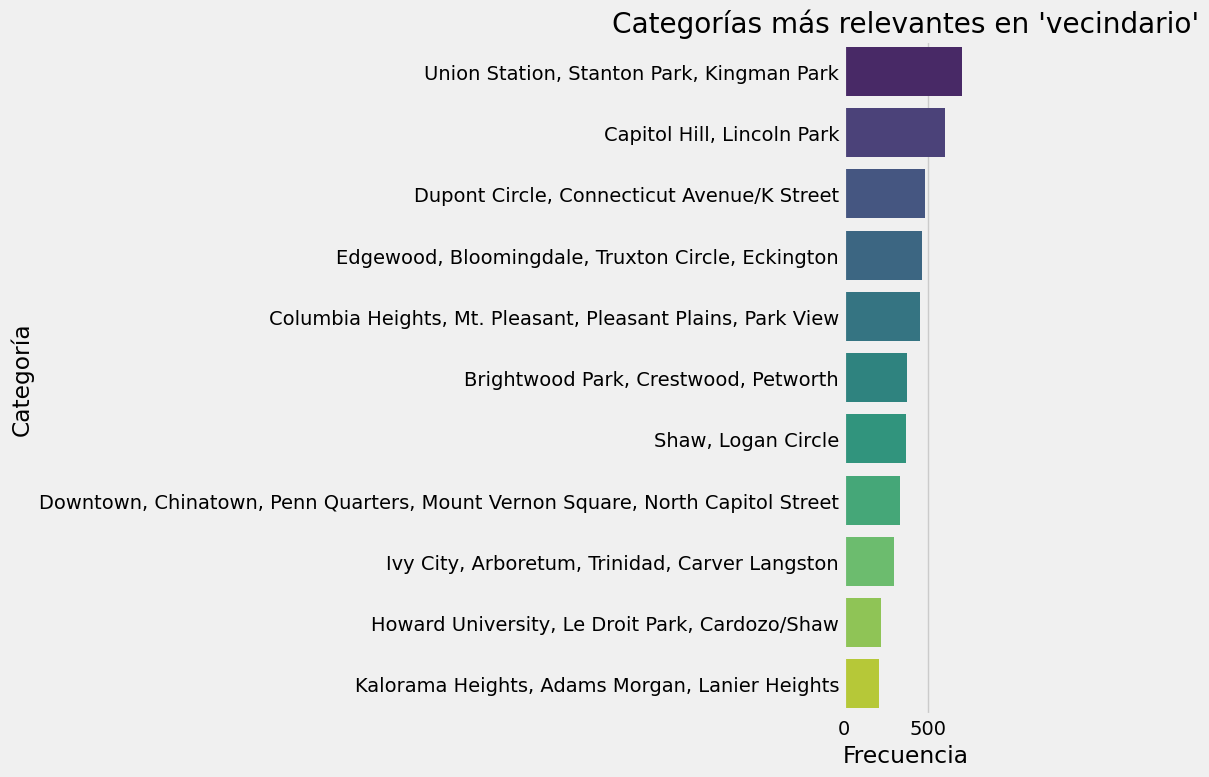

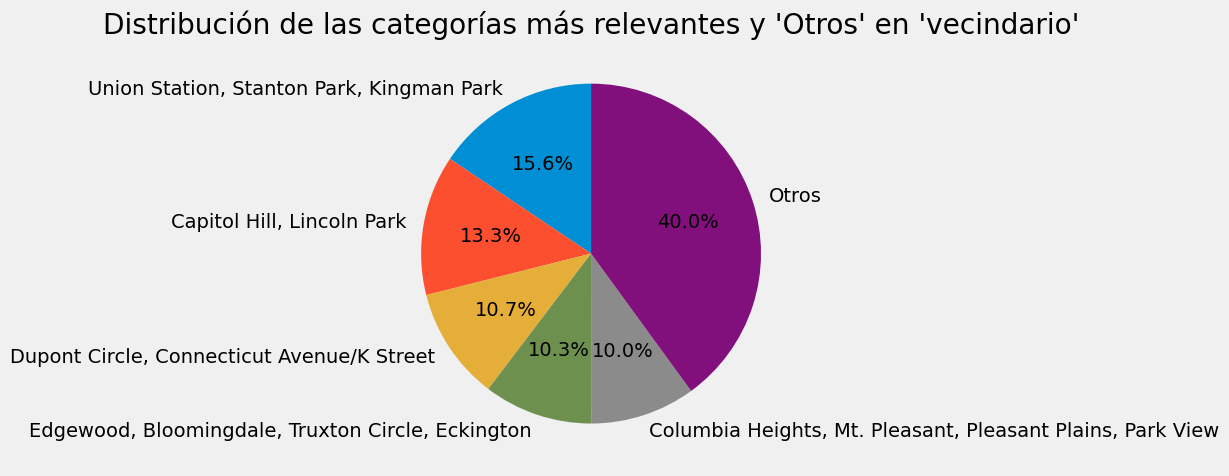


Las categorías más relevantes para 'tipo_propiedad' son:
                 tipo_propiedad  frecuencia
0            Entire rental unit        2575
1                   Entire home         953
2          Private room in home         490
3              Entire townhouse         402
4            Entire guest suite         381
5                  Entire condo         334
6   Private room in rental unit         271
7     Private room in townhouse         236
8                 Room in hotel         228
9     Entire serviced apartment         186
10       Room in boutique hotel          78
--------------------------------------------------


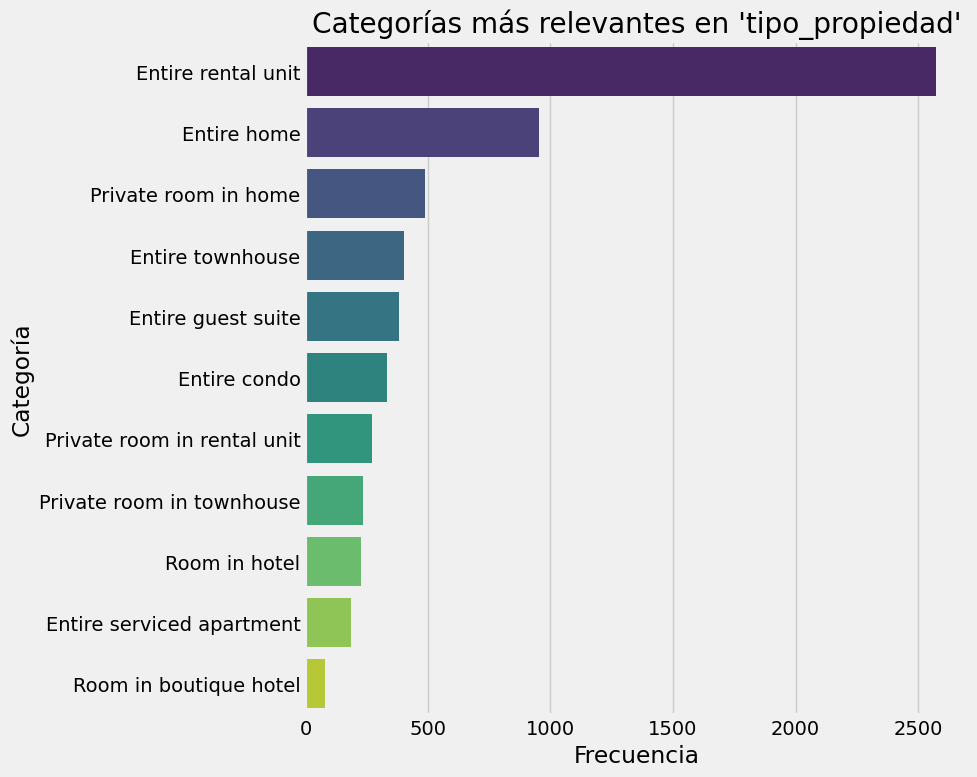

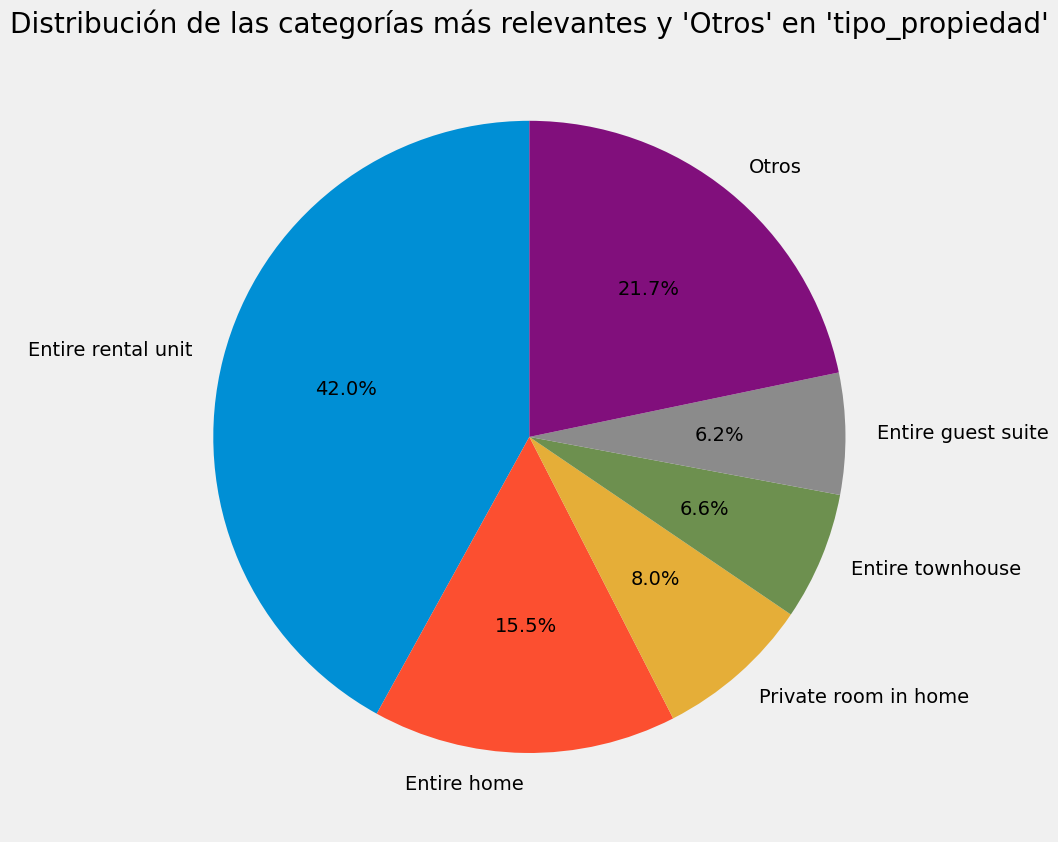


Las categorías más relevantes para 'tipo_habitacion' son:
   tipo_habitacion  frecuencia
0  Entire home/apt        4951
1     Private room        1349
2       Hotel room          94
3      Shared room          29
--------------------------------------------------


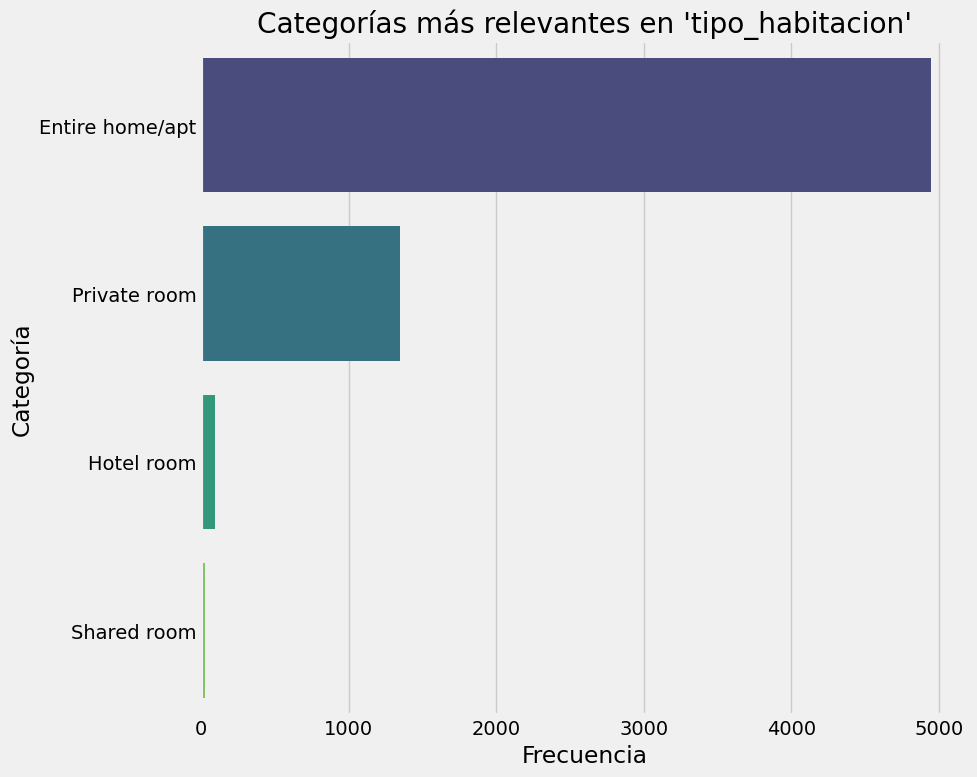

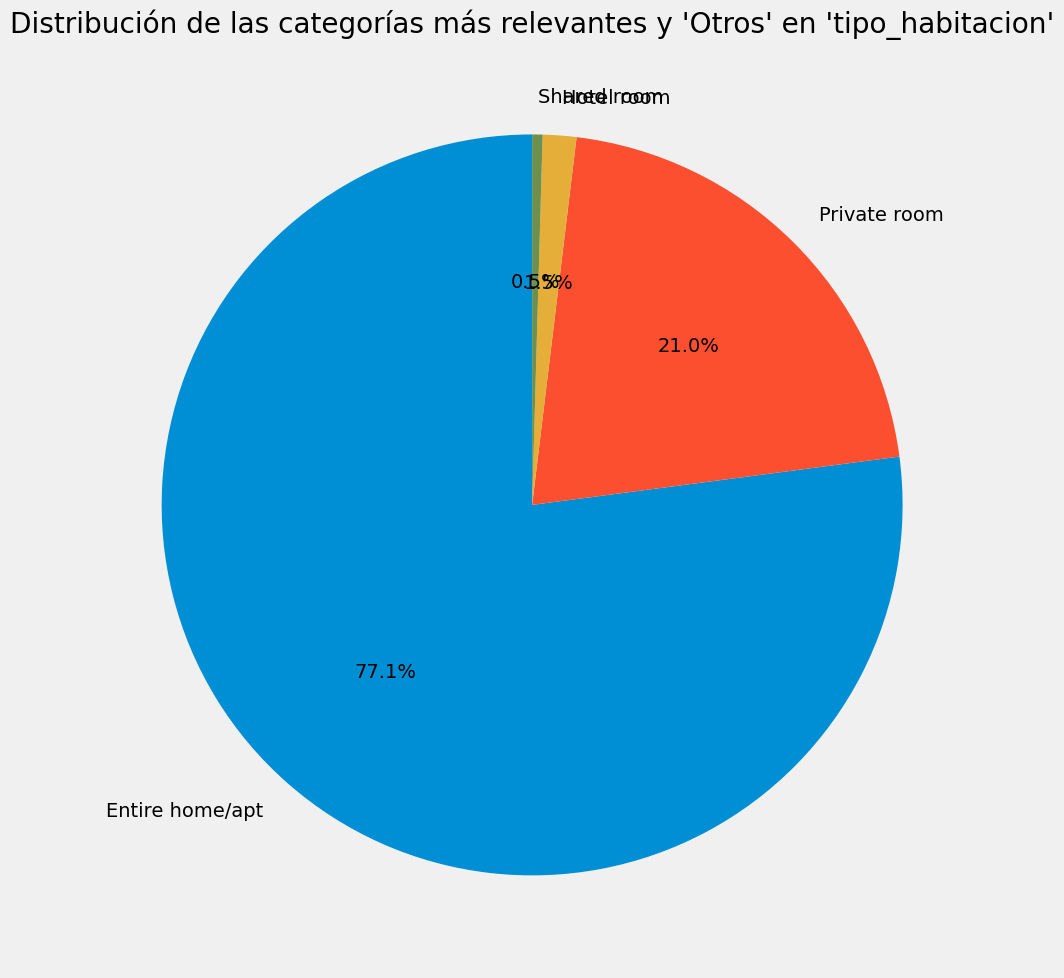


Las categorías más relevantes para 'texto_banos' son:
         texto_banos  frecuencia
0             1 bath        3528
1            2 baths         652
2     1 private bath         498
3          2.5 baths         397
4      1 shared bath         322
5          1.5 baths         300
6          3.5 baths         157
7     0 shared baths         132
8            3 baths         129
9     2 shared baths          98
10  1.5 shared baths          86
--------------------------------------------------


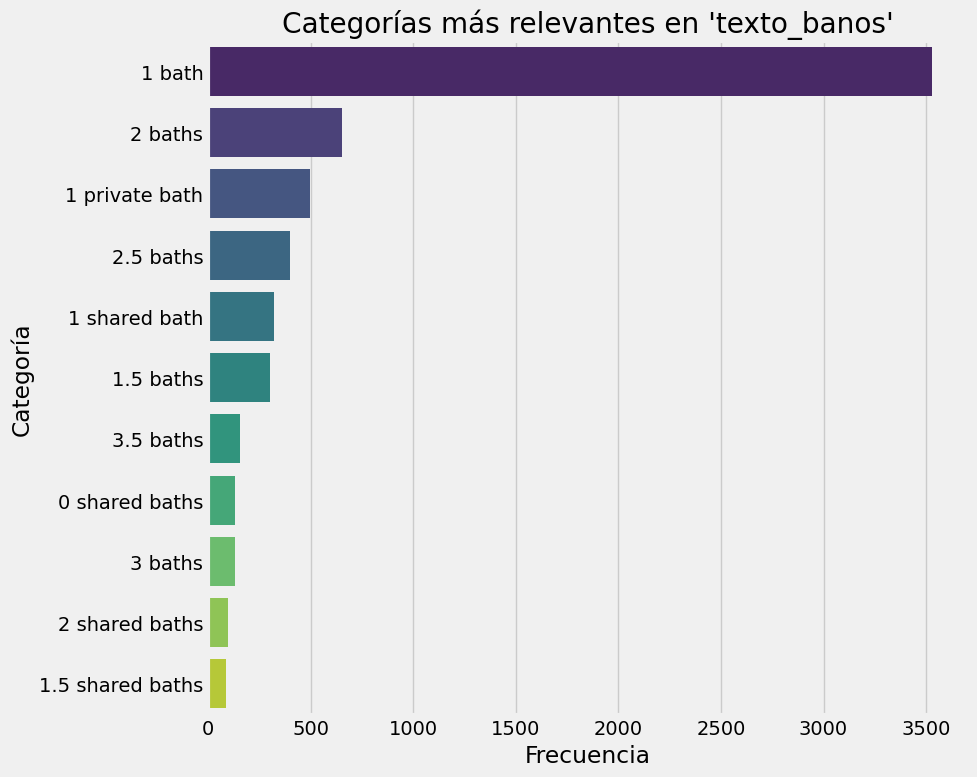

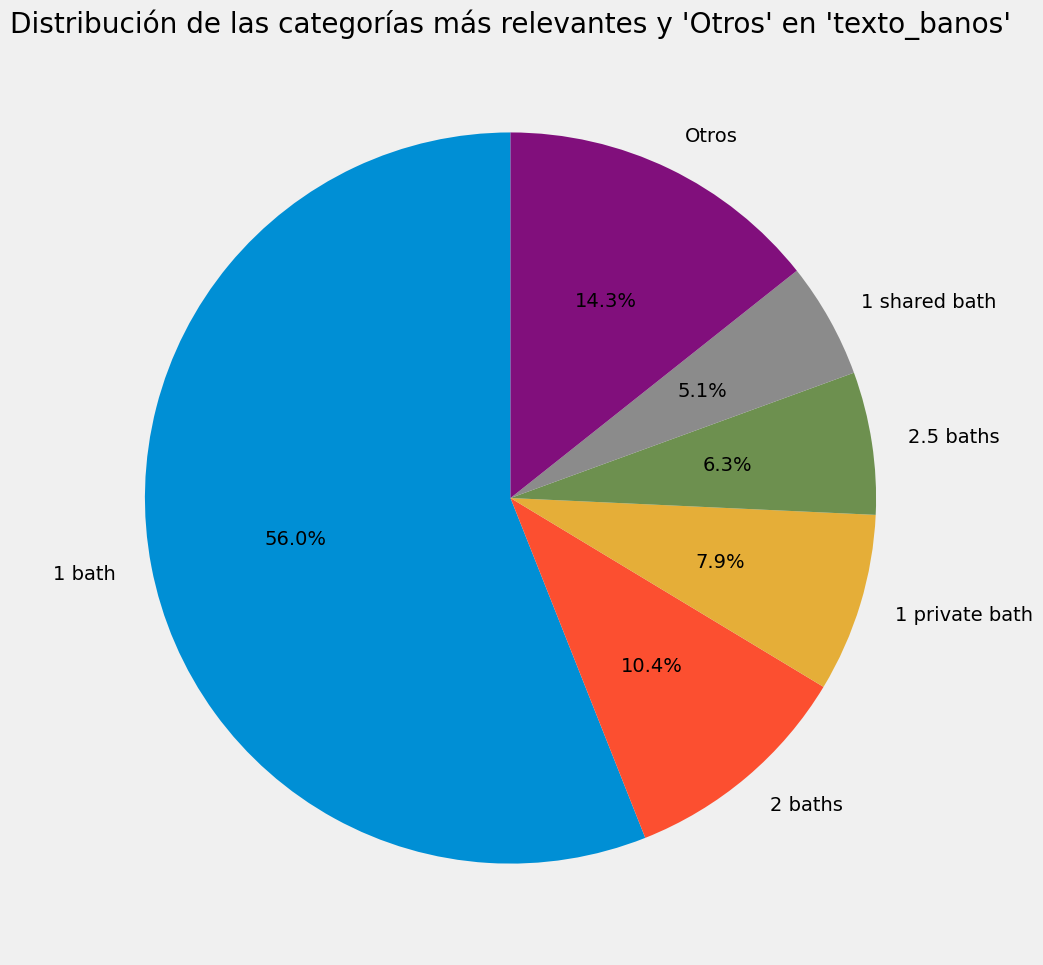


Las categorías más relevantes para 'reserva_inmediata' son:
  reserva_inmediata  frecuencia
0                 f        4161
1                 t        2262
--------------------------------------------------


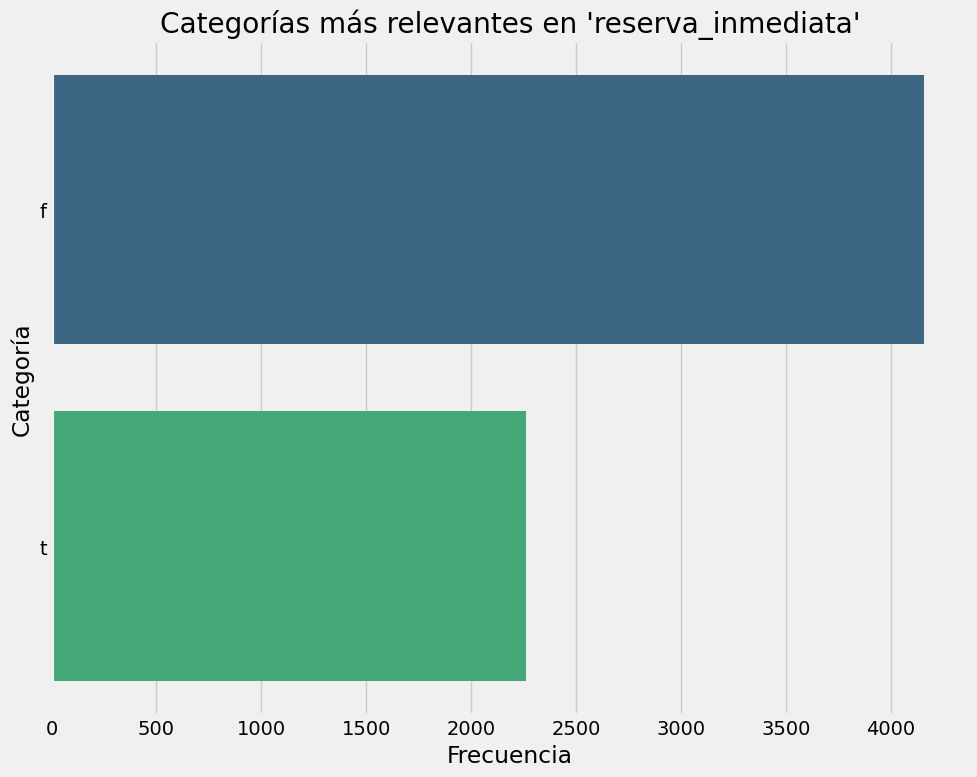

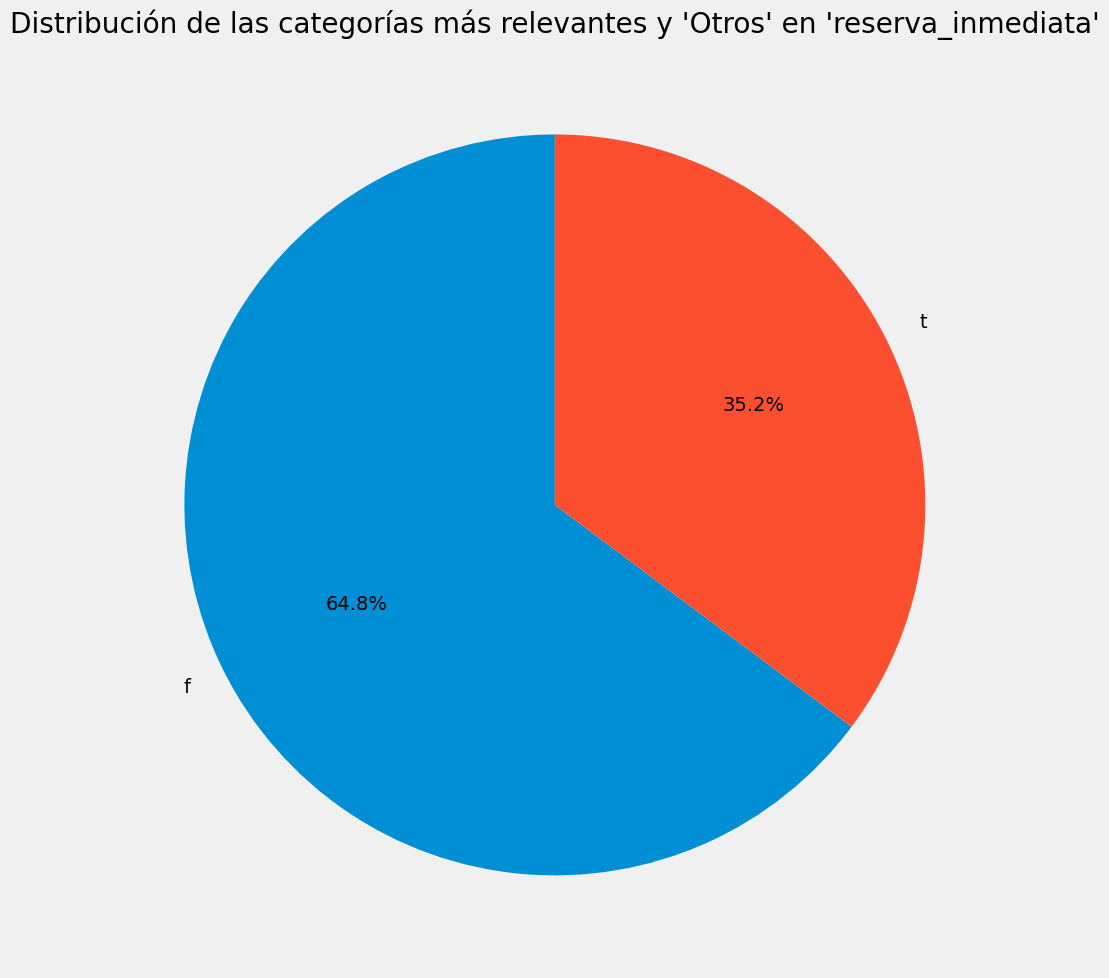


Las categorías más relevantes para 'es_superhost' son:
  es_superhost  frecuencia
0            f        3591
1            t        2713
2     SIN_INFO         119
--------------------------------------------------


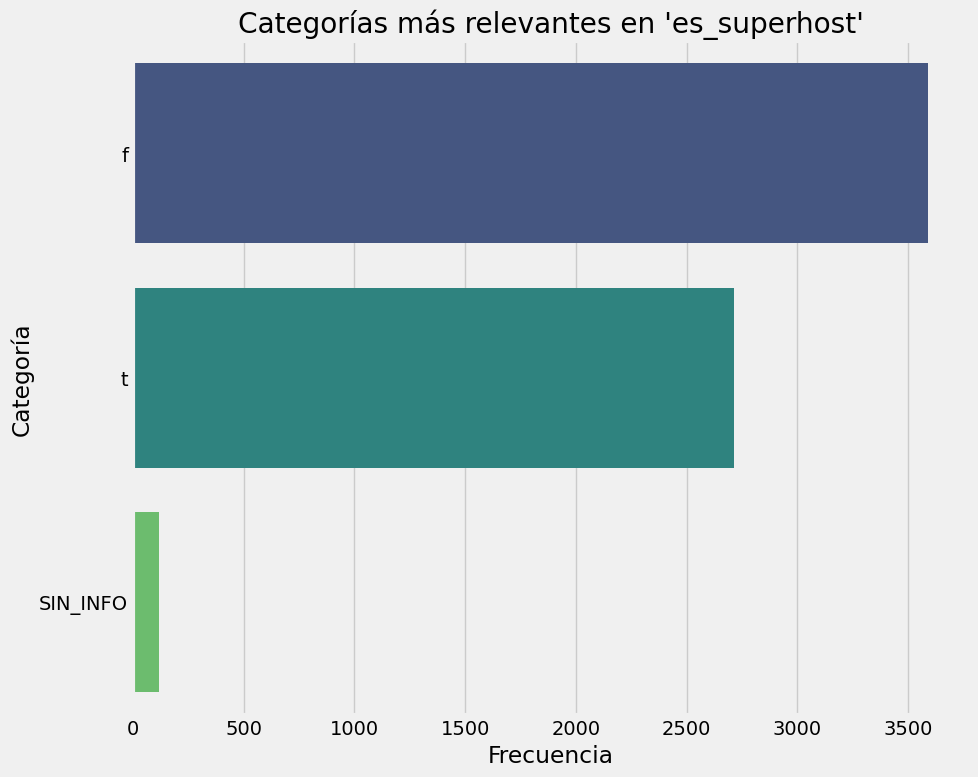

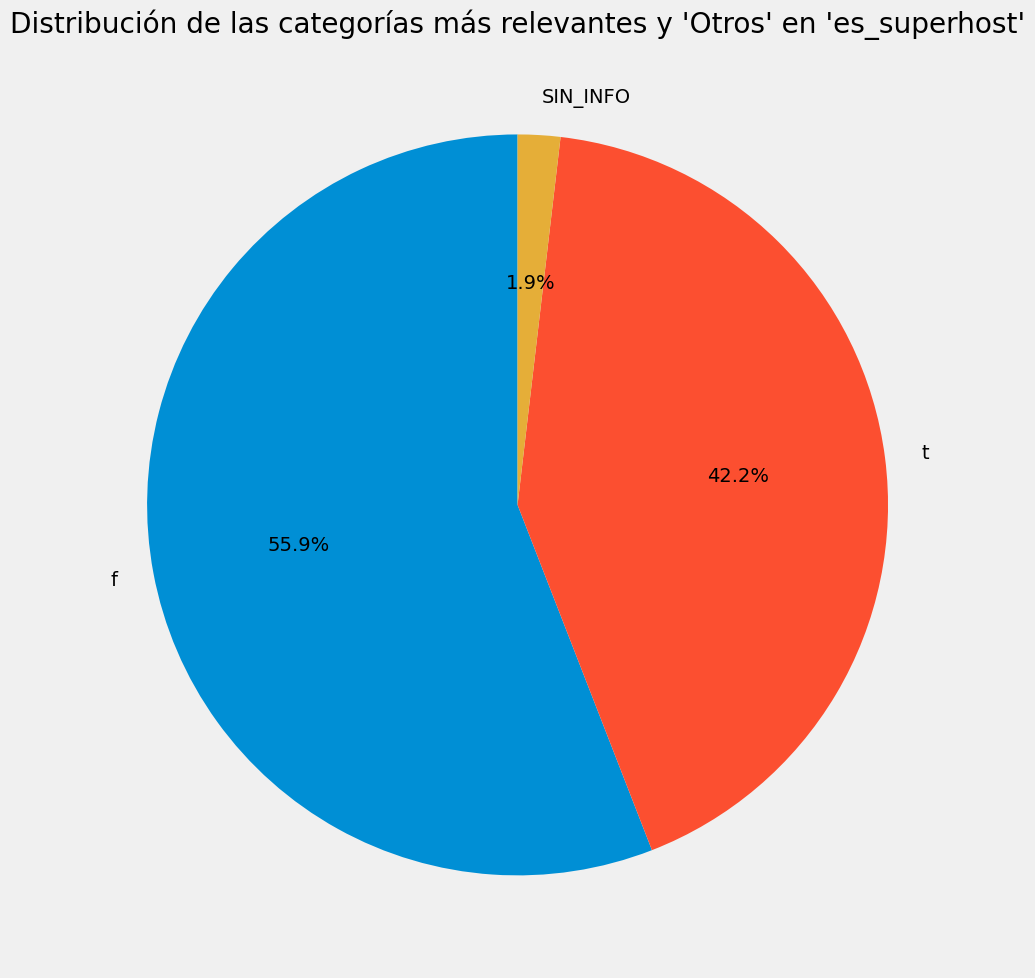


Las categorías más relevantes para 'tiempo_respuesta_host' son:
  tiempo_respuesta_host  frecuencia
0        within an hour        4802
1    within a few hours         746
2          within a day         271
3    a few days or more         138
4              SIN_INFO         466
--------------------------------------------------


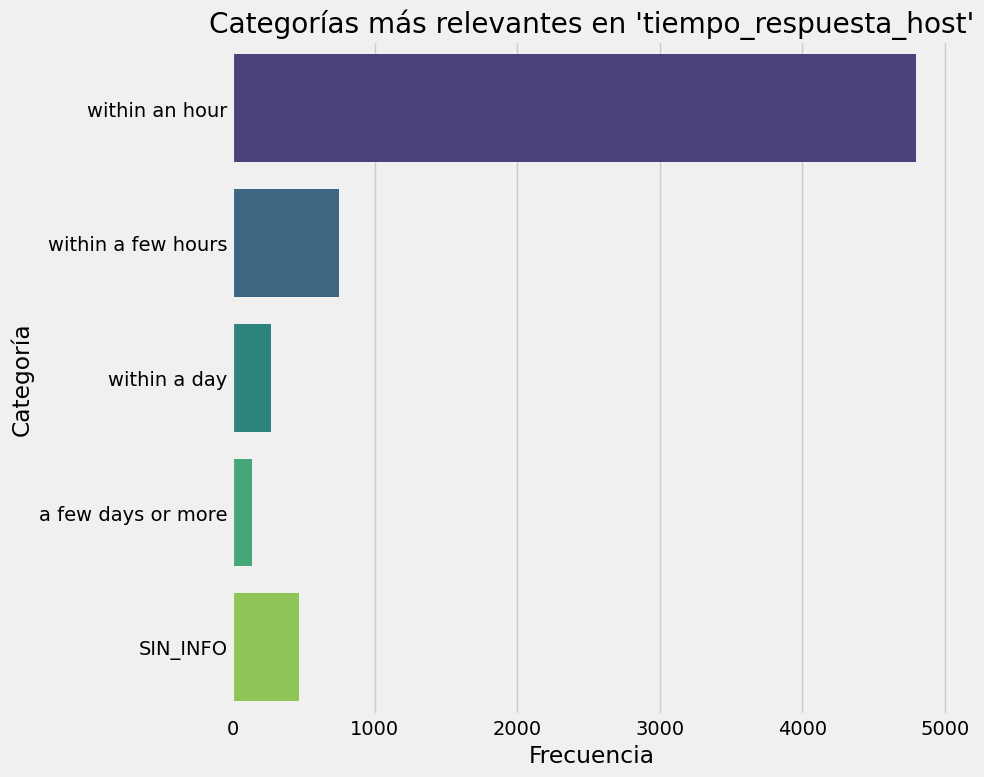

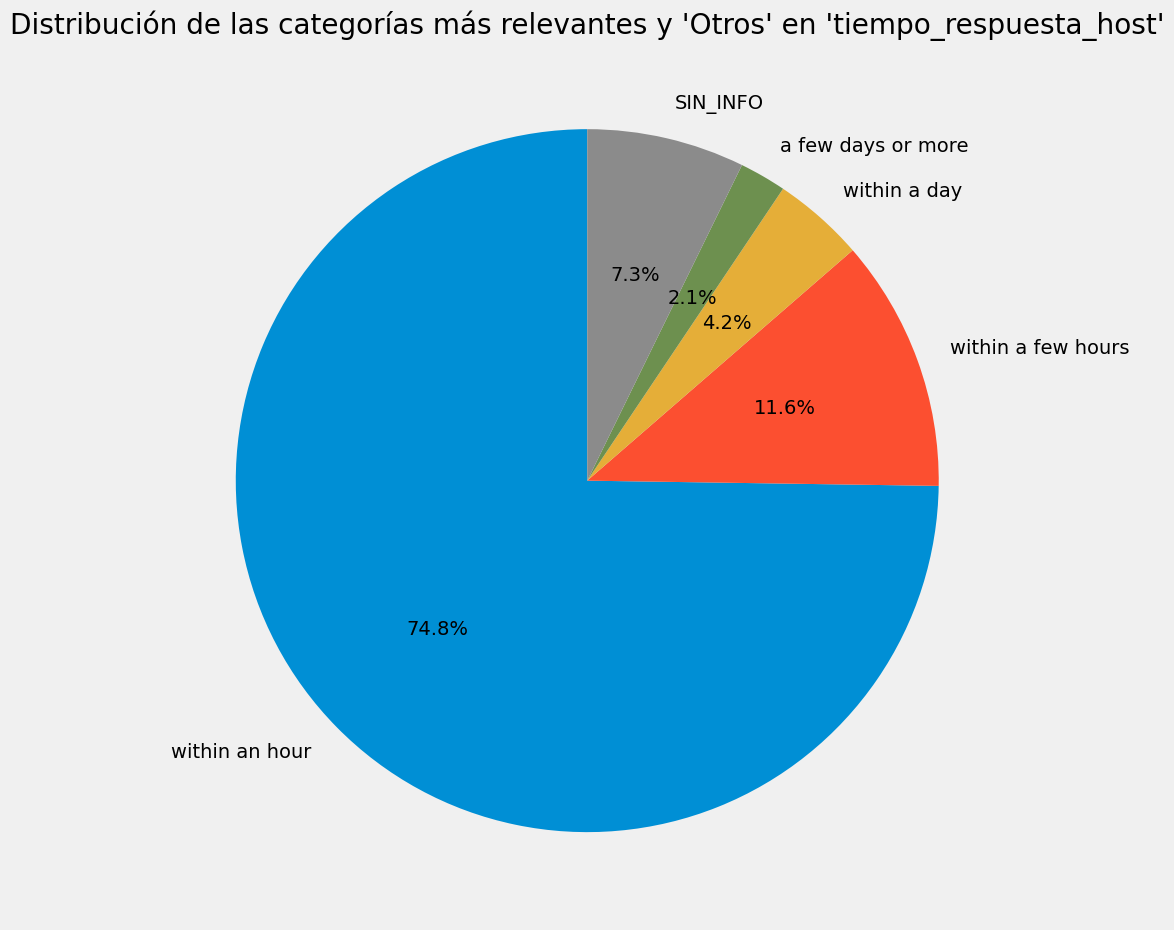


Las categorías más relevantes para 'host_tiene_foto' son:
  host_tiene_foto  frecuencia
0               t        6328
1               f          95
--------------------------------------------------


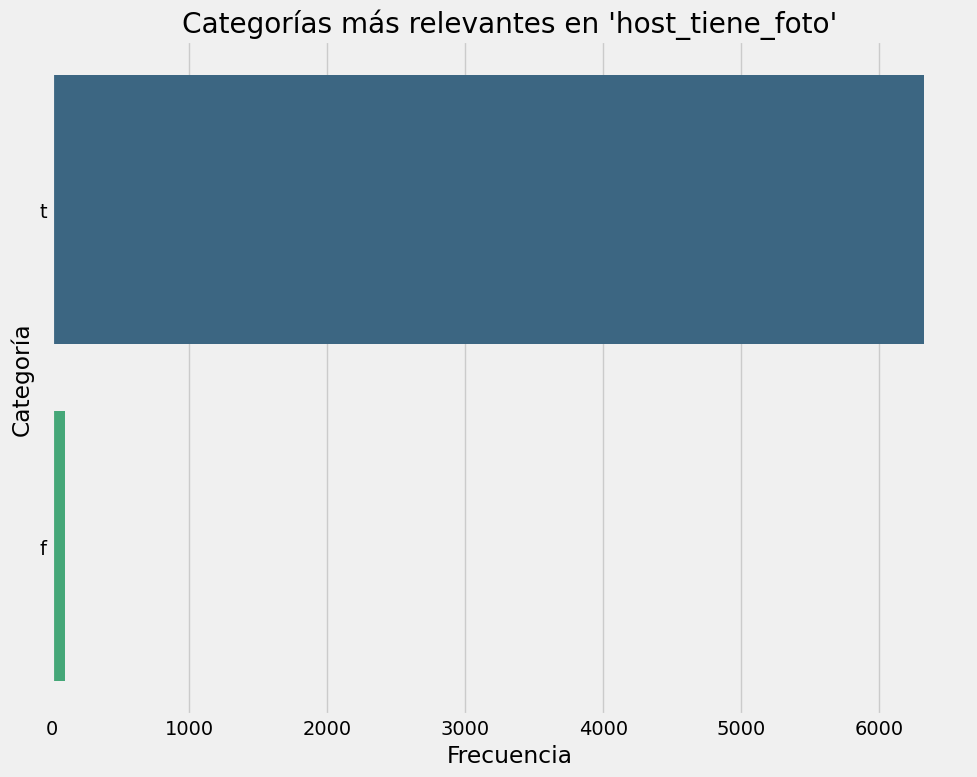

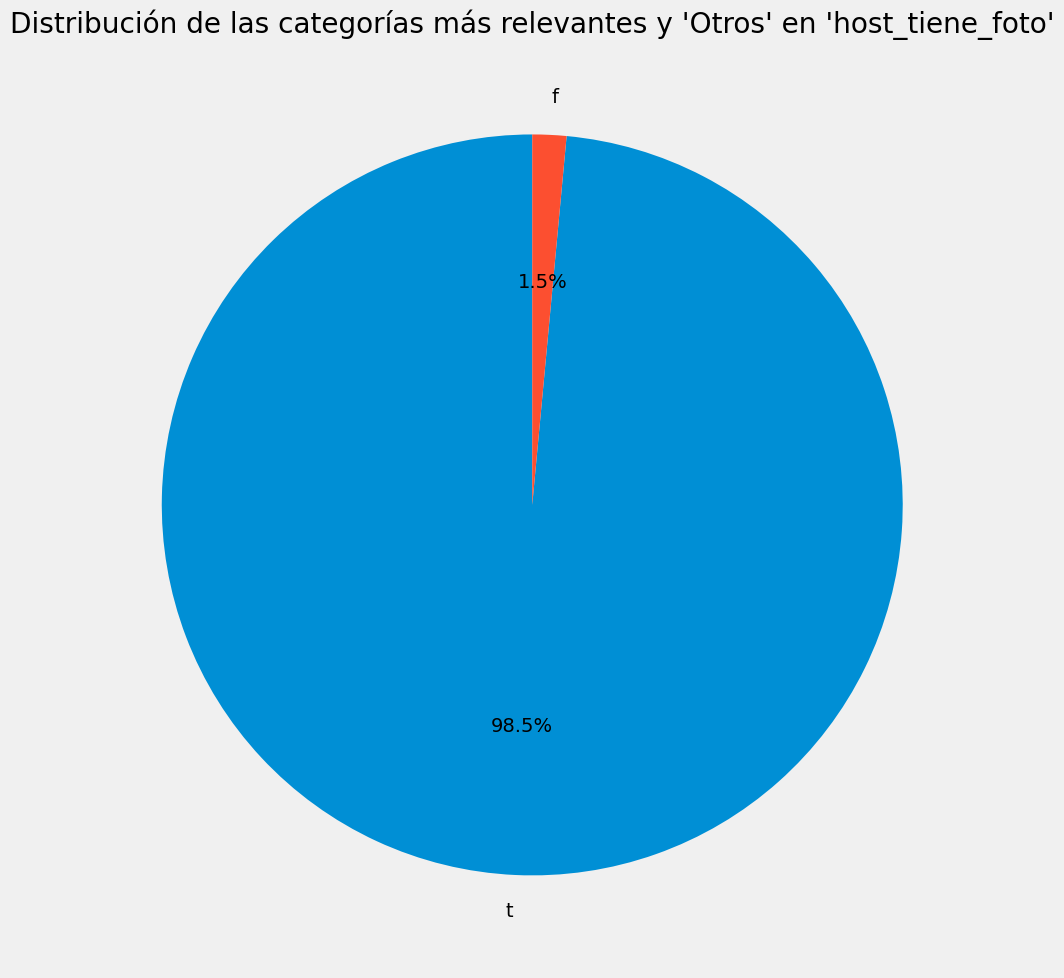


Las categorías más relevantes para 'host_verificado' son:
  host_verificado  frecuencia
0               t        5605
1               f         818
--------------------------------------------------


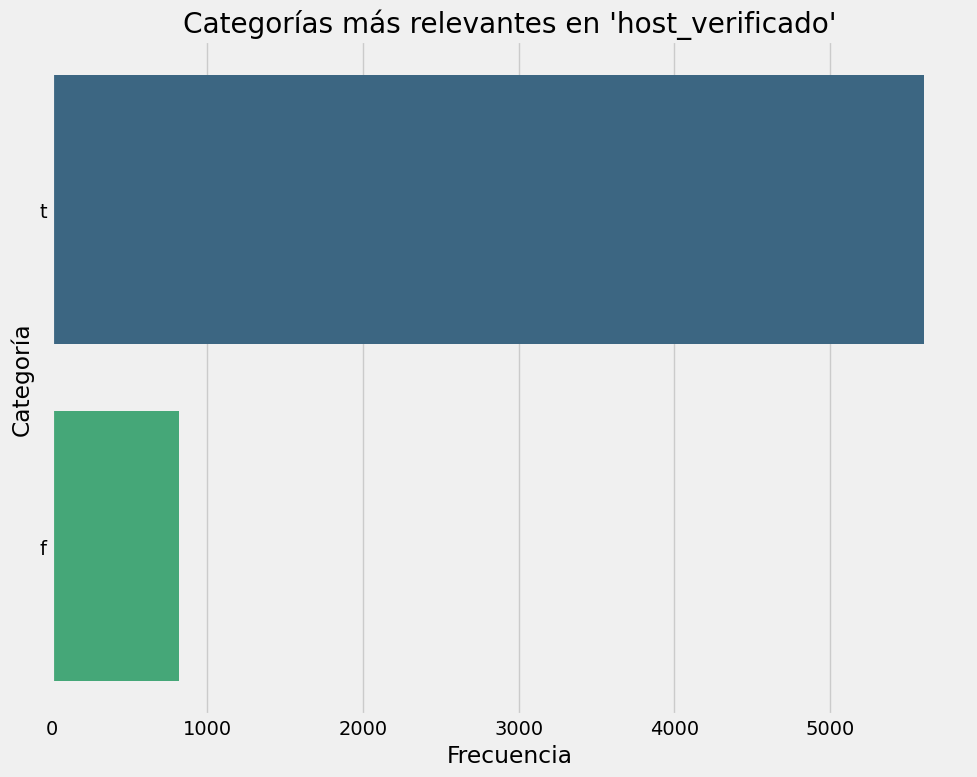

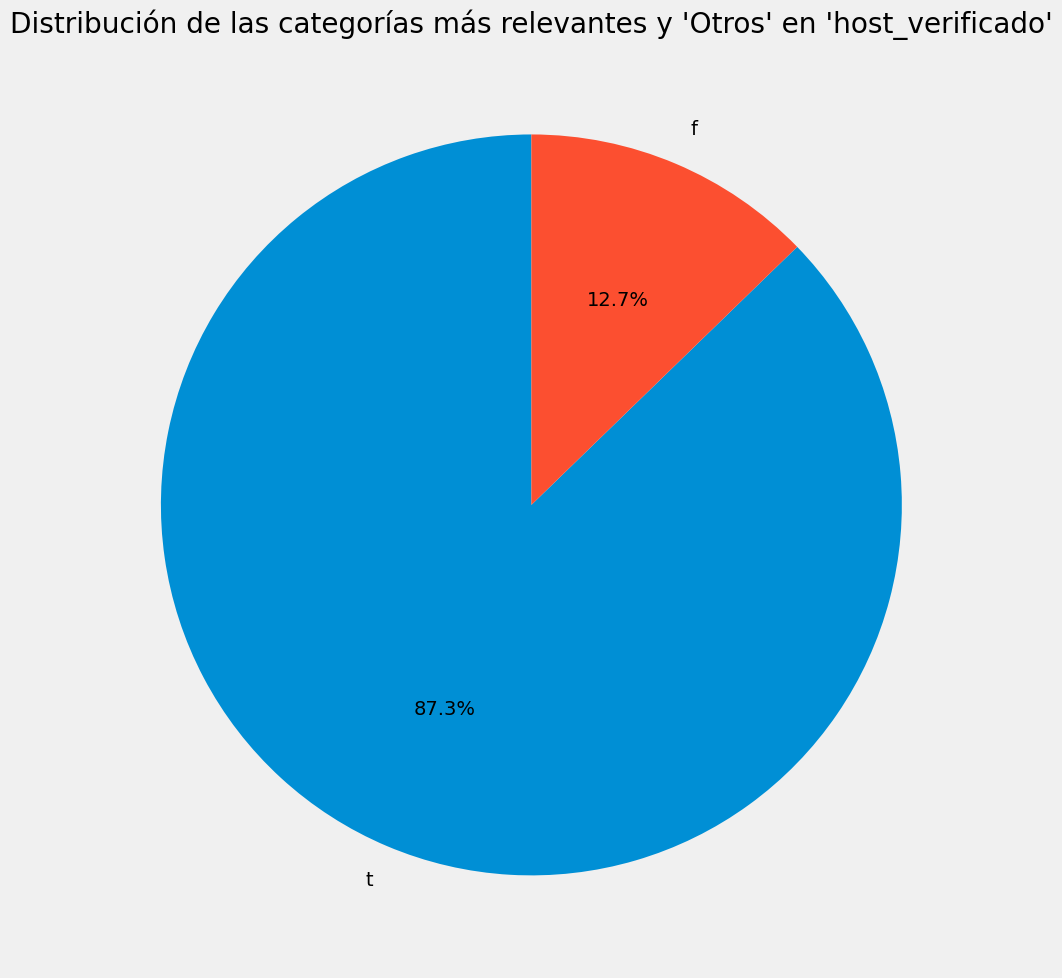

In [114]:
# =========================================================================
# Paso 14: Análisis univariado de variables categóricas
# =========================================================================
print("Paso 14: Análisis univariado de variables categóricas...")

# Análisis univariado de variables categóricas
categorical_vars = [
    'zona_grupo', 'vecindario', 'tipo_propiedad', 'tipo_habitacion',
    'texto_banos', 'reserva_inmediata', 'es_superhost',
    'tiempo_respuesta_host', 'host_tiene_foto', 'host_verificado'
]

print("--- Análisis de las categorías más relevantes en cada columna categórica ---")
for var in categorical_vars:
    vc = df[var].value_counts(dropna=False)

    sin_info_count = vc.pop('SIN_INFO') if 'SIN_INFO' in vc.index else None
    top = vc.nlargest(11 - (1 if sin_info_count is not None else 0))
    top_10 = (pd.concat([top, pd.Series({'SIN_INFO': sin_info_count})]) if sin_info_count is not None else top)
    top_10 = top_10.rename_axis(var).reset_index(name='frecuencia')

    print(f"\nLas categorías más relevantes para '{var}' son:")
    print(top_10)
    print("-" * 50)

    plt.figure(figsize=(10, 8))
    sns.barplot(
        x="frecuencia",
        y=var,
        data=top_10,
        hue=var,
        palette="viridis",
        order=top_10[var].tolist(),
        legend=False,
        errorbar=None
    )
    plt.title(f"Categorías más relevantes en '{var}'")
    plt.xlabel('Frecuencia')
    plt.ylabel('Categoría')
    plt.tight_layout()
    plt.show()

    df_pie = top_10.copy()
    otras = df_pie['frecuencia'].iloc[5:].sum()
    df_pie = df_pie.iloc[:5].copy()
    if otras > 0:
        df_pie.loc[len(df_pie)] = ['Otros', otras]

    labels_pie = df_pie[var].astype(str).replace({'nan': 'NaN'})

    plt.figure(figsize=(10, 10))
    plt.pie(
        df_pie['frecuencia'],
        labels=labels_pie,
        autopct='%1.1f%%',
        startangle=90
    )
    plt.title(f"Distribución de las categorías más relevantes y 'Otros' en '{var}'")
    plt.tight_layout()
    plt.show()


Paso 15: Distribución para discretas (capacidad, baños, camas) y categorización para el resto

Frecuencias de categorías para tasa_respuesta_host:
tasa_respuesta_host_rango_15
[0.0, 0.0667)        48
[0.0667, 0.133)       3
[0.133, 0.2)          3
[0.2, 0.267)          7
[0.267, 0.333)        4
[0.4, 0.467)         72
[0.467, 0.533)       23
[0.533, 0.6)          8
[0.6, 0.667)         49
[0.667, 0.733)       31
[0.733, 0.8)         26
[0.8, 0.867)        105
[0.867, 0.933)      231
[0.933, 1.0)       5347
SIN_INFO            466
Name: count, dtype: int64


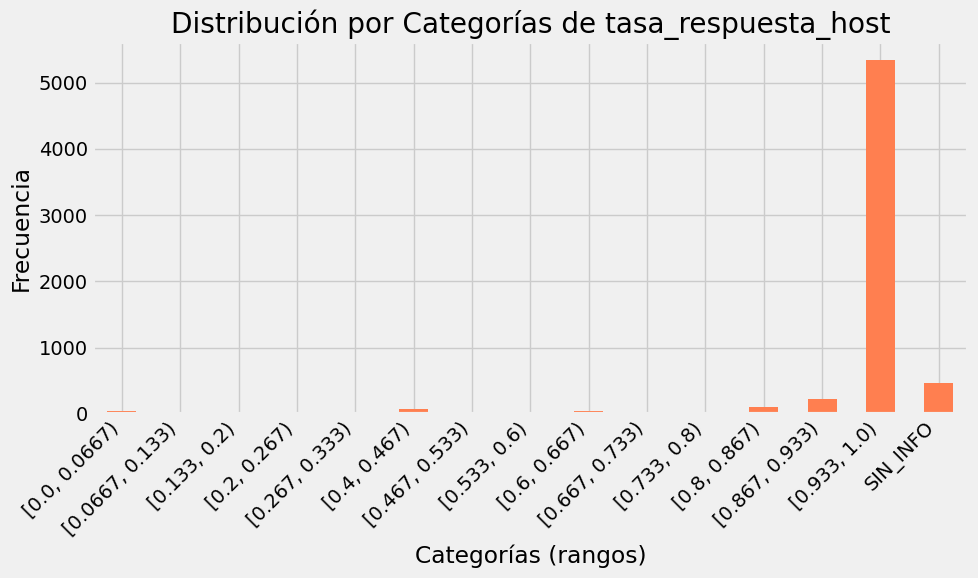


Frecuencias de categorías para tasa_aceptacion_host:
tasa_aceptacion_host_rango_15
[0.75, 0.767)       94
[0.767, 0.783)      36
[0.783, 0.8)        33
[0.8, 0.817)        60
[0.817, 0.833)      50
[0.833, 0.85)        9
[0.85, 0.867)      138
[0.867, 0.883)     168
[0.883, 0.9)        76
[0.9, 0.917)       118
[0.917, 0.933)     176
[0.933, 0.95)      155
[0.95, 0.967)      322
[0.967, 0.983)     963
[0.983, 1.0)      3725
SIN_INFO           300
Name: count, dtype: int64


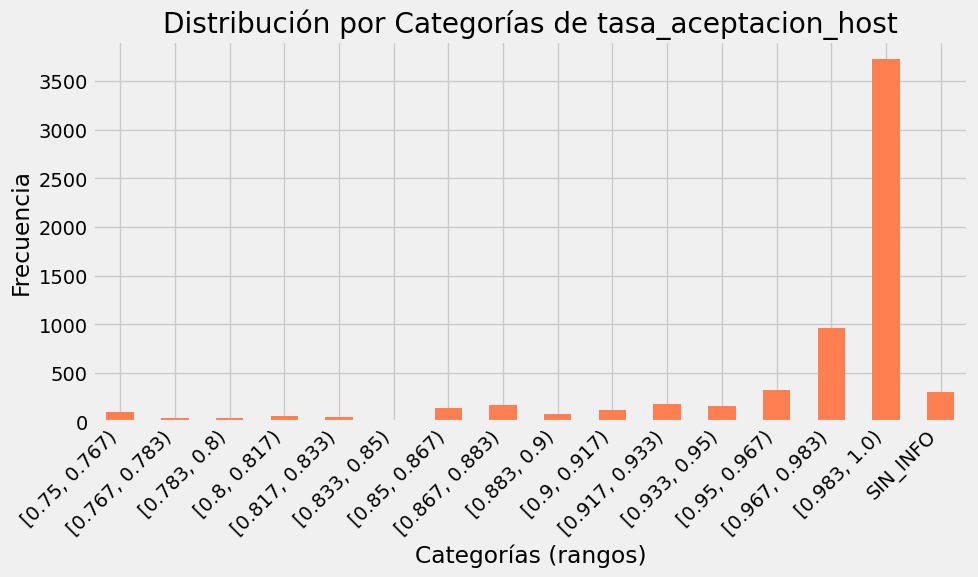


Frecuencias de categorías para total_listados_host:
total_listados_host_rango_15
[1.0, 5.067)        4749
[5.067, 9.133)       634
[9.133, 13.2)        199
[13.2, 17.267)       266
[17.267, 21.333)     135
[21.333, 25.4)        91
[25.4, 29.467)        67
[29.467, 33.533)      70
[33.533, 37.6)        90
[37.6, 41.667)        44
[41.667, 45.733)      26
[45.733, 49.8)        10
[49.8, 53.867)        33
[57.933, 62.0)         9
Name: count, dtype: int64


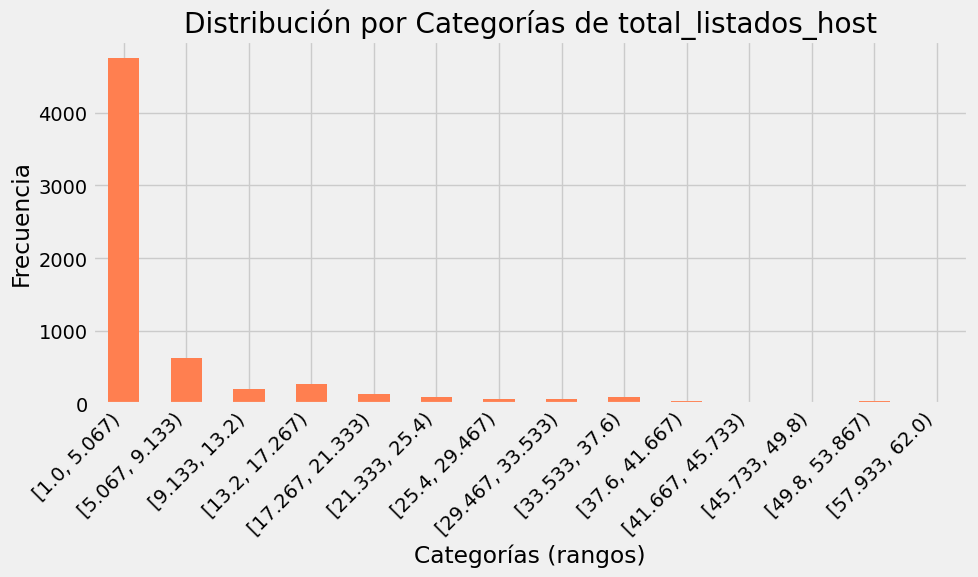


Frecuencias para capacidad (enteros 0..14):
0        0
1      518
2     2076
3      924
4     1490
5      448
6      555
7      116
8      256
9       40
10       0
11       0
12       0
13       0
14       0
Name: count, dtype: Int64


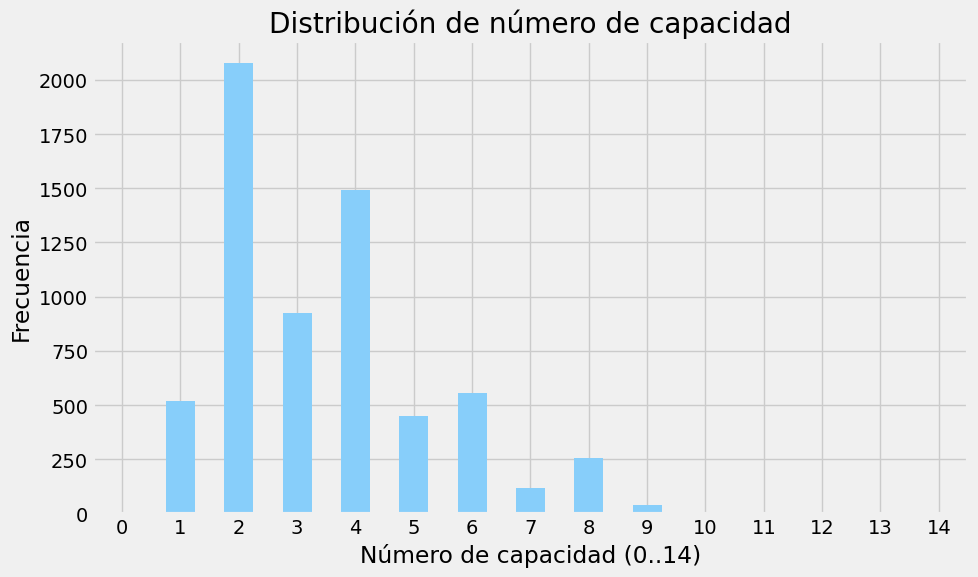


Frecuencias para banos (enteros 0..14):
0      137
1     4359
2     1136
3      568
4      189
5       29
6        3
7        1
8        0
9        1
10       0
11       0
12       0
13       0
14       0
Name: count, dtype: Int64


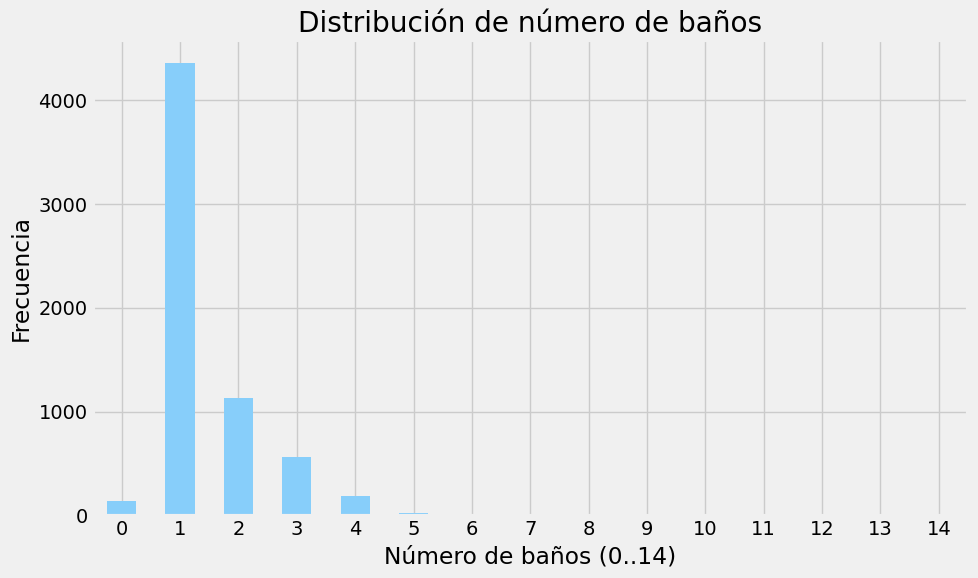


Frecuencias para camas (enteros 0..14):
0       45
1     4250
2     1551
3      577
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
Name: count, dtype: Int64


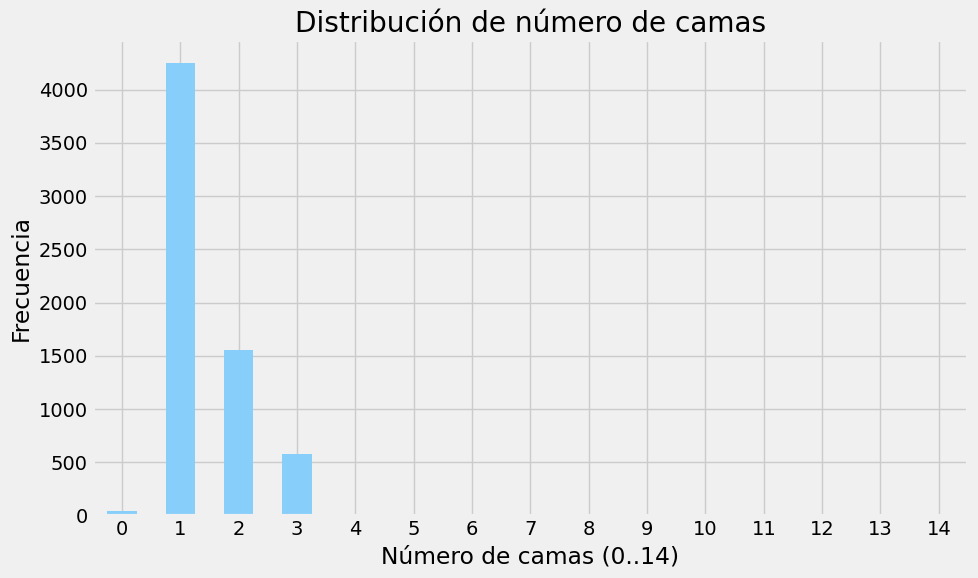


Frecuencias de categorías para precio:
precio_rango_15
[10.0, 63.6)       437
[63.6, 117.2)     1512
[117.2, 170.8)    1304
[170.8, 224.4)     708
[224.4, 278.0)     396
[278.0, 331.6)     185
[331.6, 385.2)     120
[385.2, 438.8)    1656
[438.8, 492.4)      39
[492.4, 546.0)      18
[546.0, 599.6)      20
[599.6, 653.2)      10
[653.2, 706.8)       5
[706.8, 760.4)       8
[760.4, 814.0)       5
Name: count, dtype: int64


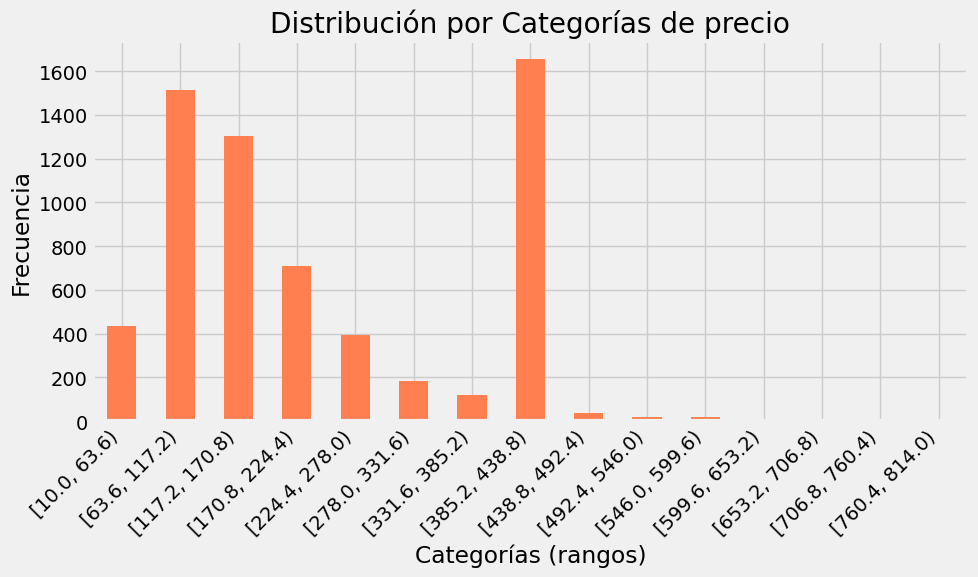


Frecuencias de categorías para max_noches_maximas:
max_noches_maximas_rango_15
[1.0, 122.6)        1209
[122.6, 244.2)       133
[244.2, 365.8)      1664
[365.8, 487.4)        18
[487.4, 609.0)        14
[609.0, 730.6)       123
[730.6, 852.2)        90
[973.8, 1095.4)       41
[1095.4, 1217.0)    3130
[1703.4, 1825.0)       1
Name: count, dtype: int64


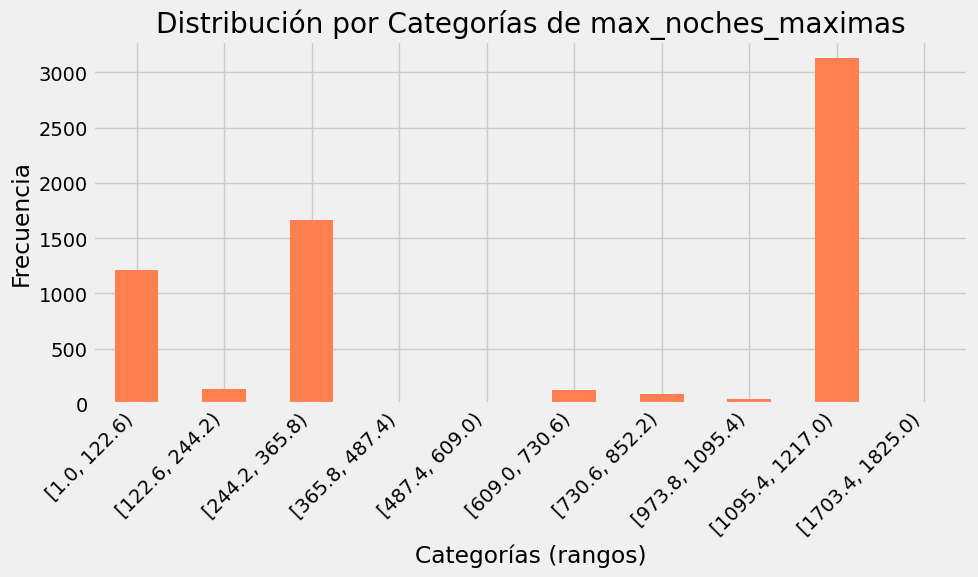


Frecuencias de categorías para disp_365d:
disp_365d_rango_15
[0.0, 24.333)          616
[24.333, 48.667)       265
[48.667, 73.0)         265
[73.0, 97.333)         294
[97.333, 121.667)      213
[121.667, 146.0)       249
[146.0, 170.333)       380
[170.333, 194.667)     309
[194.667, 219.0)       260
[219.0, 243.333)       352
[243.333, 267.667)     437
[267.667, 292.0)       360
[292.0, 316.333)       591
[316.333, 340.667)     708
[340.667, 365.0)      1124
Name: count, dtype: int64


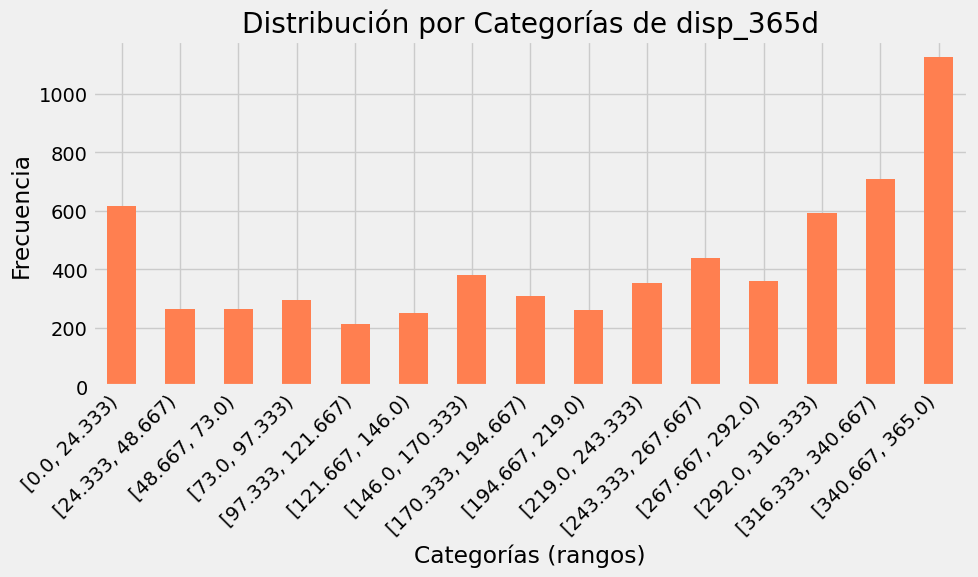


Frecuencias de categorías para num_resenas:
num_resenas_rango_15
[0.0, 14.6)       2871
[14.6, 29.2)      1309
[29.2, 43.8)       405
[43.8, 58.4)       331
[58.4, 73.0)       245
[73.0, 87.6)       216
[87.6, 102.2)      203
[102.2, 116.8)     182
[116.8, 131.4)     128
[131.4, 146.0)     115
[146.0, 160.6)     116
[160.6, 175.2)      75
[175.2, 189.8)      79
[189.8, 204.4)      92
[204.4, 219.0)      56
Name: count, dtype: int64


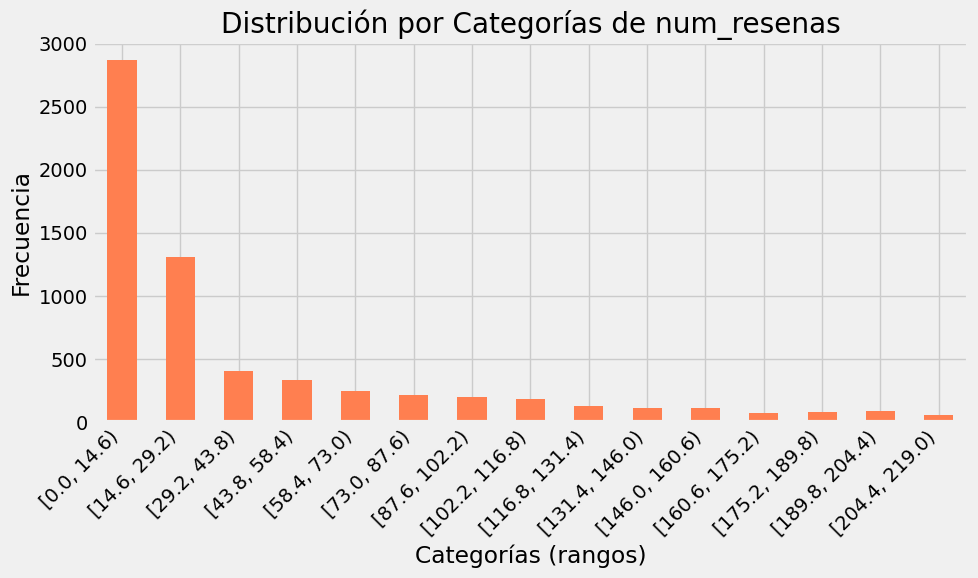


Frecuencias de categorías para calif_total:
calif_total_rango_15
[0.0, 0.333)         1
[1.0, 1.333)        10
[1.333, 1.667)       2
[2.0, 2.333)        15
[2.333, 2.667)       2
[2.667, 3.0)         5
[3.0, 3.333)        36
[3.333, 3.667)      17
[3.667, 4.0)        21
[4.0, 4.333)       220
[4.333, 4.667)     750
[4.667, 5.0)      4249
SIN_INFO          1095
Name: count, dtype: int64


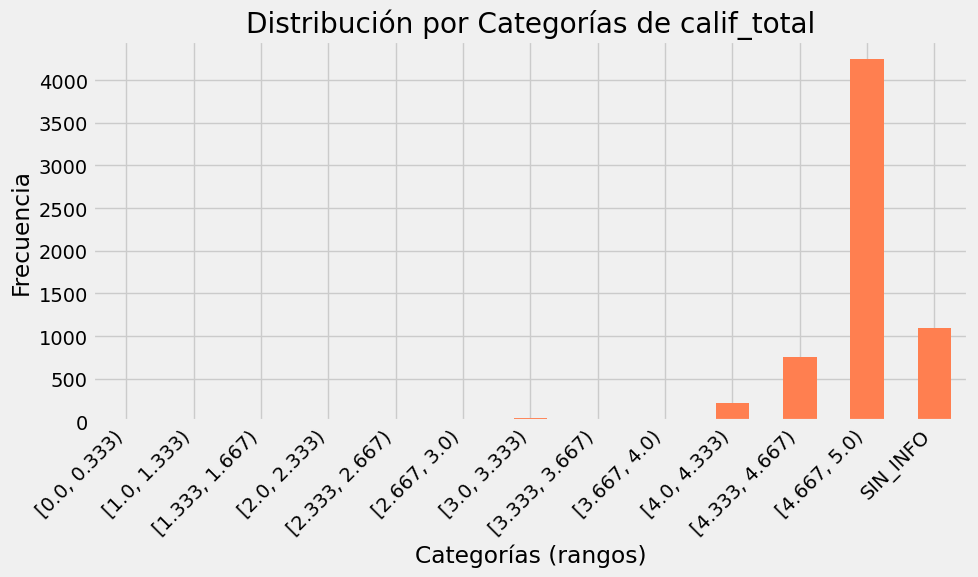


Frecuencias de categorías para calif_valor:
calif_valor_rango_15
[1.0, 1.267)        12
[1.267, 1.533)       2
[1.533, 1.8)         1
[1.8, 2.067)        16
[2.067, 2.333)       1
[2.333, 2.6)         4
[2.867, 3.133)      50
[3.133, 3.4)        10
[3.4, 3.667)        22
[3.667, 3.933)      38
[3.933, 4.2)       169
[4.2, 4.467)       367
[4.467, 4.733)    1375
[4.733, 5.0)      3260
SIN_INFO          1096
Name: count, dtype: int64


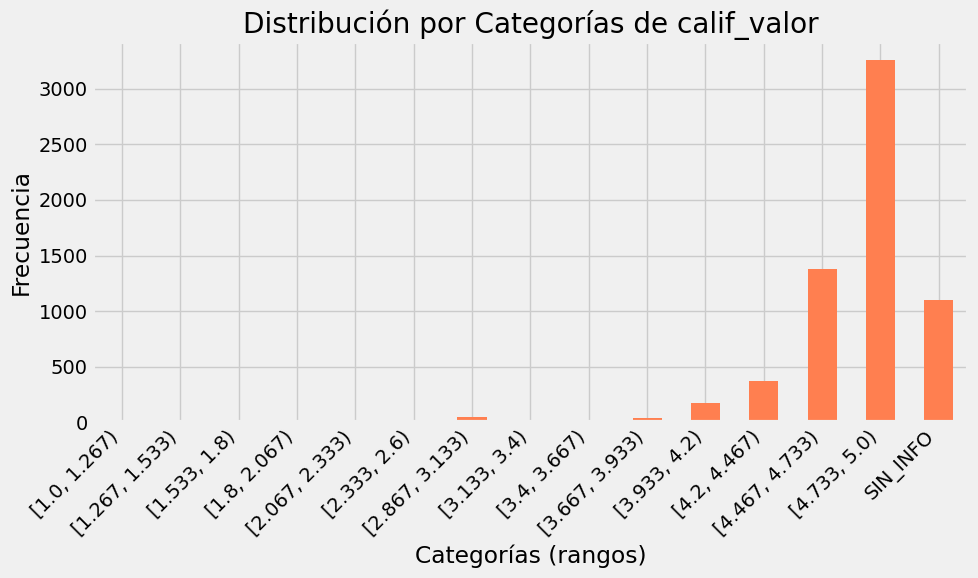


Frecuencias de categorías para resenas_por_mes:
resenas_por_mes_rango_15
[0.01, 0.473)     1347
[0.473, 0.937)     611
[0.937, 1.4)       538
[1.4, 1.863)       571
[1.863, 2.327)     432
[2.327, 2.79)      381
[2.79, 3.253)      337
[3.253, 3.717)     248
[3.717, 4.18)      236
[4.18, 4.643)      195
[4.643, 5.107)     152
[5.107, 5.57)       84
[5.57, 6.033)       85
[6.033, 6.497)      65
[6.497, 6.96)       46
SIN_INFO          1095
Name: count, dtype: int64


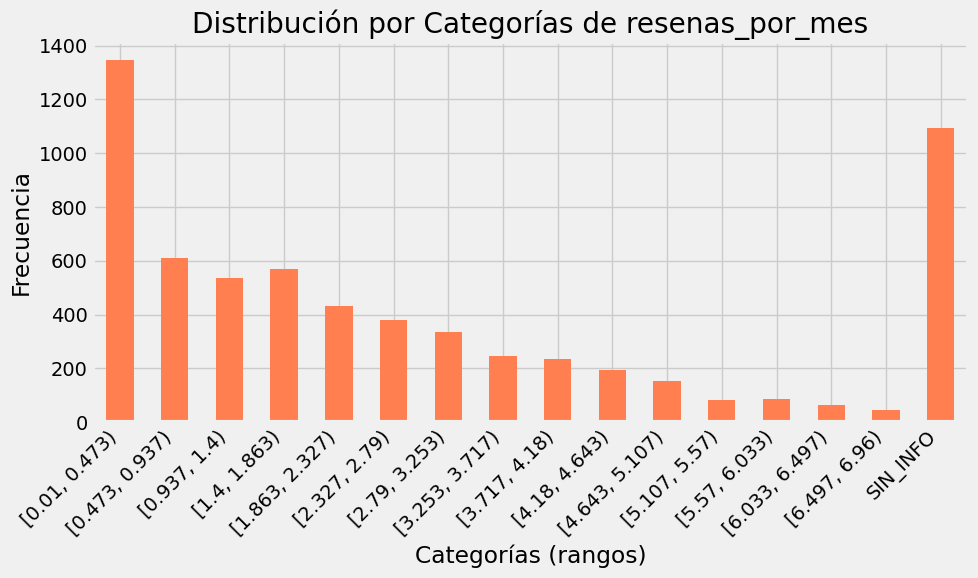

In [115]:
# =========================================================================
# Paso 15: Distribución para discretas (capacidad, baños, camas) y categorización para el resto
# =========================================================================
print("Paso 15: Distribución para discretas (capacidad, baños, camas) y categorización para el resto")

# Usar DF limpio si existe
df_src = df_work

# Variables
numerical_vars = [
    'tasa_respuesta_host', 'tasa_aceptacion_host', 'total_listados_host',
    'capacidad', 'banos', 'camas', 'precio', 'max_noches_maximas',
    'disp_365d', 'num_resenas', 'calif_total', 'calif_valor', 'resenas_por_mes'
]
DISCRETAS = {'capacidad', 'banos', 'camas'}
NOMBRE_EJE = {'capacidad': 'capacidad', 'banos': 'baños', 'camas': 'camas'}

# Para DISCRETAS: 15 categorías fijas empezando en 0 ⇒ 0..14
NUM_CATEGORIAS_DISCRETAS = 15
DISCRETE_MIN = 0
DISCRETE_MAX = DISCRETE_MIN + NUM_CATEGORIAS_DISCRETAS - 1  # 14

NUM_BINS_CONTINUAS = 15

# --- helper para redondeo half-up a entero ---
def round_half_up_to_int(series):
    arr = pd.to_numeric(series, errors='coerce')
    return np.floor(arr + 0.5)

for var in numerical_vars:
    # Serie numérica limpia + centinela a NaN si aplica
    s = pd.to_numeric(df_src[var], errors='coerce')
    sentinel_val = sentinel_dict_num.get(var)
    s = s.mask(s == sentinel_val, pd.NA)

    s_valid = s.dropna()
    if s_valid.empty:
        print(f"\n{var}: no hay datos válidos.")
        continue

    # ---------- DISCRETAS: capacidad, banos, camas ----------
    if var in DISCRETAS:
        vals = round_half_up_to_int(s_valid).clip(lower=DISCRETE_MIN, upper=DISCRETE_MAX).astype("Int64")
        categorias_fijas = pd.Index(range(DISCRETE_MIN, DISCRETE_MAX + 1), dtype="Int64")
        conteo = vals.value_counts().sort_index().reindex(categorias_fijas, fill_value=0)

        print(f"\nFrecuencias para {var} (enteros {DISCRETE_MIN}..{DISCRETE_MAX}):")
        print(conteo)

        # Gráfico
        plt.figure(figsize=(10, 6))
        conteo.plot(kind='bar', color='lightskyblue')
        plt.title(f"Distribución de número de {NOMBRE_EJE.get(var, var)}")
        plt.xlabel(f"Número de {NOMBRE_EJE.get(var, var)} ({DISCRETE_MIN}..{DISCRETE_MAX})")
        plt.ylabel("Frecuencia")
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()
        continue

    # ---------- CONTINUAS: resto con 15 bins (solo rangos con datos) ----------
    Min, Max = float(s_valid.min()), float(s_valid.max())
    if Max == Min:
        Max = Min + 1e-9

    edges = np.linspace(Min, Max, NUM_BINS_CONTINUAS + 1)
    edges[-1] = np.nextafter(edges[-1], np.inf)

    cats = pd.cut(s, bins=edges, right=False, include_lowest=True, ordered=True)

    # Añadir SIN_INFO solo si existe faltante y eliminar categorías vacías
    if cats.isna().any():
        cats = cats.cat.add_categories(['SIN_INFO']).fillna('SIN_INFO')
    cats = cats.cat.remove_unused_categories()

    df_src[f"{var}_rango_15"] = cats

    counts = df_src[f"{var}_rango_15"].value_counts(sort=False)
    if 'SIN_INFO' in counts.index:
        counts = counts[[*(i for i in counts.index if i != 'SIN_INFO'), 'SIN_INFO']]

    print(f"\nFrecuencias de categorías para {var}:")
    print(counts.rename(index=lambda x: str(x)))

    plt.figure(figsize=(10, 6))
    counts.rename(index=lambda x: str(x)).plot(kind='bar', color='coral')
    plt.title(f'Distribución por Categorías de {var}')
    plt.xlabel('Categorías (rangos)')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [116]:
df_work.shape

(6423, 60)

In [117]:
# =========================================================================
# Paso 16: Exportación del DataFrame final
# =========================================================================
print("Paso 16: Exportación del DataFrame final...")

OUTPUT_FINAL = CARPETA_TRABAJO / f"{BASE_NAME}_FINAL.csv"
df_work.to_csv(OUTPUT_FINAL, index=False, encoding="utf-8-sig")

print(f"Archivo final exportado como '{OUTPUT_FINAL.name}' ✅")


Paso 16: Exportación del DataFrame final...


Archivo final exportado como 'Washington_FINAL.csv' ✅
